In [ ]:
! sudo apt-get install texlive-latex-recommended 
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Input, LSTM
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import matplotlib
import pickle
import seaborn as sn

In [ ]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
matplotlib.rcParams['text.latex.unicode']=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import sys


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.66.180.82:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.66.180.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.66.180.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Xd = pd.read_pickle("/content/drive/MyDrive/RML2016.10a_dict.pkl")

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.6)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

NameError: ignored

In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

print(X_train.transpose((0,2,1)).shape)

X_train = X_train.transpose((0,2,1))
X_test = X_test.transpose((0,2,1))

(110000, 2, 128) [2, 128]
(110000, 128, 2)


In [ ]:
class peel_the_layer(tf.keras.layers.Layer): 
      def __init__(self):    
          ##Nothing special to be done here
          super(peel_the_layer, self).__init__()
          
      def build(self, input_shape):
          ##Define the shape of the weights and bias in this layer
          ##This is a 1 unit layer. 
          units=1
          ##last index of the input_shape is the number of dimensions of the prev
          ##RNN layer. last but 1 index is the num of timesteps
          self.w=self.add_weight(name="att_weights", shape=(input_shape[-1], units), initializer="normal") #name property is useful for avoiding RuntimeError: Unable to create link.
          self.b=self.add_weight(name="att_bias", shape=(input_shape[-2], units), initializer="zeros")
          super(peel_the_layer,self).build(input_shape)
          
      def call(self, x):
          ##x is the input tensor..each word that needs to be attended to
          ##Below is the main processing done during training
          ##K is the Keras Backend import
          e = K.tanh(K.dot(x,self.w)+self.b)
          a = K.softmax(e, axis=1)
          output = x*a
          
          ##return the ouputs. 'a' is the set of attention weights
          ##the second variable is the 'attention adjusted o/p state' or context
          return K.sum(output, axis=1)

In [ ]:
inputs = Input(shape=(None, 128, 2))

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = keras.Sequential()
  model.add(layers.Bidirectional(LSTM(32, return_sequences=True)))
  model.add(layers.Bidirectional(LSTM(32, return_sequences=True)))
  model.add(layers.Bidirectional(LSTM(32, return_sequences=True)))
  model.add(peel_the_layer())
  #sum = layer.Concatenate()
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(32, activation="relu"))

  model.add(layers.Dense(11, activation="softmax"))

  model.build((None,128,2))
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])
  model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128, 64)          8960      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 64)          24832     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128, 64)          24832     
 nal)                                                            
                                                                 
 peel_the_layer (peel_the_la  (None, 64)               192       
 yer)                                                            
                                                                 
 dense (Dense)               (None, 32)                2

In [ ]:
filepath = 'BiLSTM.wts.h5'
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    #show_accuracy=True,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
108/108 - 58s - loss: 2.3289 - val_loss: 2.2307 - 58s/epoch - 533ms/step
Epoch 2/100
108/108 - 20s - loss: 2.2163 - val_loss: 2.1967 - 20s/epoch - 181ms/step
Epoch 3/100
108/108 - 20s - loss: 2.1792 - val_loss: 2.1605 - 20s/epoch - 181ms/step
Epoch 4/100
108/108 - 19s - loss: 2.1617 - val_loss: 2.1772 - 19s/epoch - 175ms/step
Epoch 5/100
108/108 - 19s - loss: 2.1531 - val_loss: 2.1551 - 19s/epoch - 173ms/step
Epoch 6/100
108/108 - 19s - loss: 2.1423 - val_loss: 2.1426 - 19s/epoch - 173ms/step
Epoch 7/100
108/108 - 19s - loss: 2.0605 - val_loss: 2.0102 - 19s/epoch - 171ms/step
Epoch 8/100
108/108 - 19s - loss: 1.9018 - val_loss: 1.7840 - 19s/epoch - 172ms/step
Epoch 9/100
108/108 - 19s - loss: 1.7412 - val_loss: 1.7105 - 19s/epoch - 173ms/step
Epoch 10/100
108/108 - 19s - loss: 1.6867 - val_loss: 1.6798 - 19s/epoch - 173ms/step
Epoch 11/100
108/108 - 19s - loss: 1.6573 - val_loss: 1.6411 - 19s/epoch - 173ms/step
Epoch 12/100
108/108 - 18s - loss: 1.7188 - val_loss: 1.8812 - 

In [ ]:
filepath = 'BiLSTM.wts.h5'
model.load_weights(filepath)

In [ ]:
score = model.evaluate(X_test, Y_test, batch_size=1024)
print(score)

108/108 [==============================] - 19s 54ms/step - loss: 1.1314 - accuracy: 0.5688
[1.1314066648483276, 0.5688273310661316]


In [ ]:
with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

INFO:tensorflow:Assets written to: ram://09b28c2d-a67f-4a70-8200-42a2ce206582/assets


INFO:tensorflow:Assets written to: ram://09b28c2d-a67f-4a70-8200-42a2ce206582/assets


In [ ]:
textwidth = 6.10356
#figure.set_size_inches(w=textwidth/2.5)


In [ ]:
print(history.history["loss"])

[2.3288564682006836, 2.2162997722625732, 2.1792256832122803, 2.1617417335510254, 2.1531338691711426, 2.142310857772827, 2.060539722442627, 1.9018285274505615, 1.7411656379699707, 1.686692476272583, 1.6572928428649902, 1.718780279159546, 1.7072253227233887, 1.5940450429916382, 1.5604283809661865, 1.5457160472869873, 1.531563639640808, 1.5199854373931885, 1.5128124952316284, 1.5013126134872437, 1.4989315271377563, 1.4892263412475586, 1.481063723564148, 1.4735007286071777, 1.4696651697158813, 1.4592039585113525, 1.4554202556610107, 1.450777530670166, 1.4416390657424927, 1.4383755922317505, 1.4323047399520874, 1.4297655820846558, 1.4261870384216309, 1.4349137544631958, 1.4229509830474854, 1.4174165725708008, 1.416550874710083, 1.412841558456421, 1.4085012674331665, 1.4086252450942993, 1.4084877967834473, 1.401609182357788, 1.3996312618255615, 1.3995819091796875, 1.3964178562164307, 1.3921754360198975, 1.3894846439361572, 1.4495738744735718, 1.386645793914795, 1.382583737373352, 1.380263566

<Figure size 3542.14x2280 with 0 Axes>

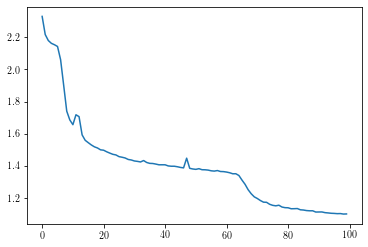

In [ ]:
matplotlib.pyplot.figure(figsize=(textwidth-0.2,3.8), dpi=600)
plt.figure()
plt.plot(history.epoch,history.history['loss'], label='train loss+error')
plt.savefig("/content/sample_data/Test.png")
#plt.xticks(epochs)
plt.show()

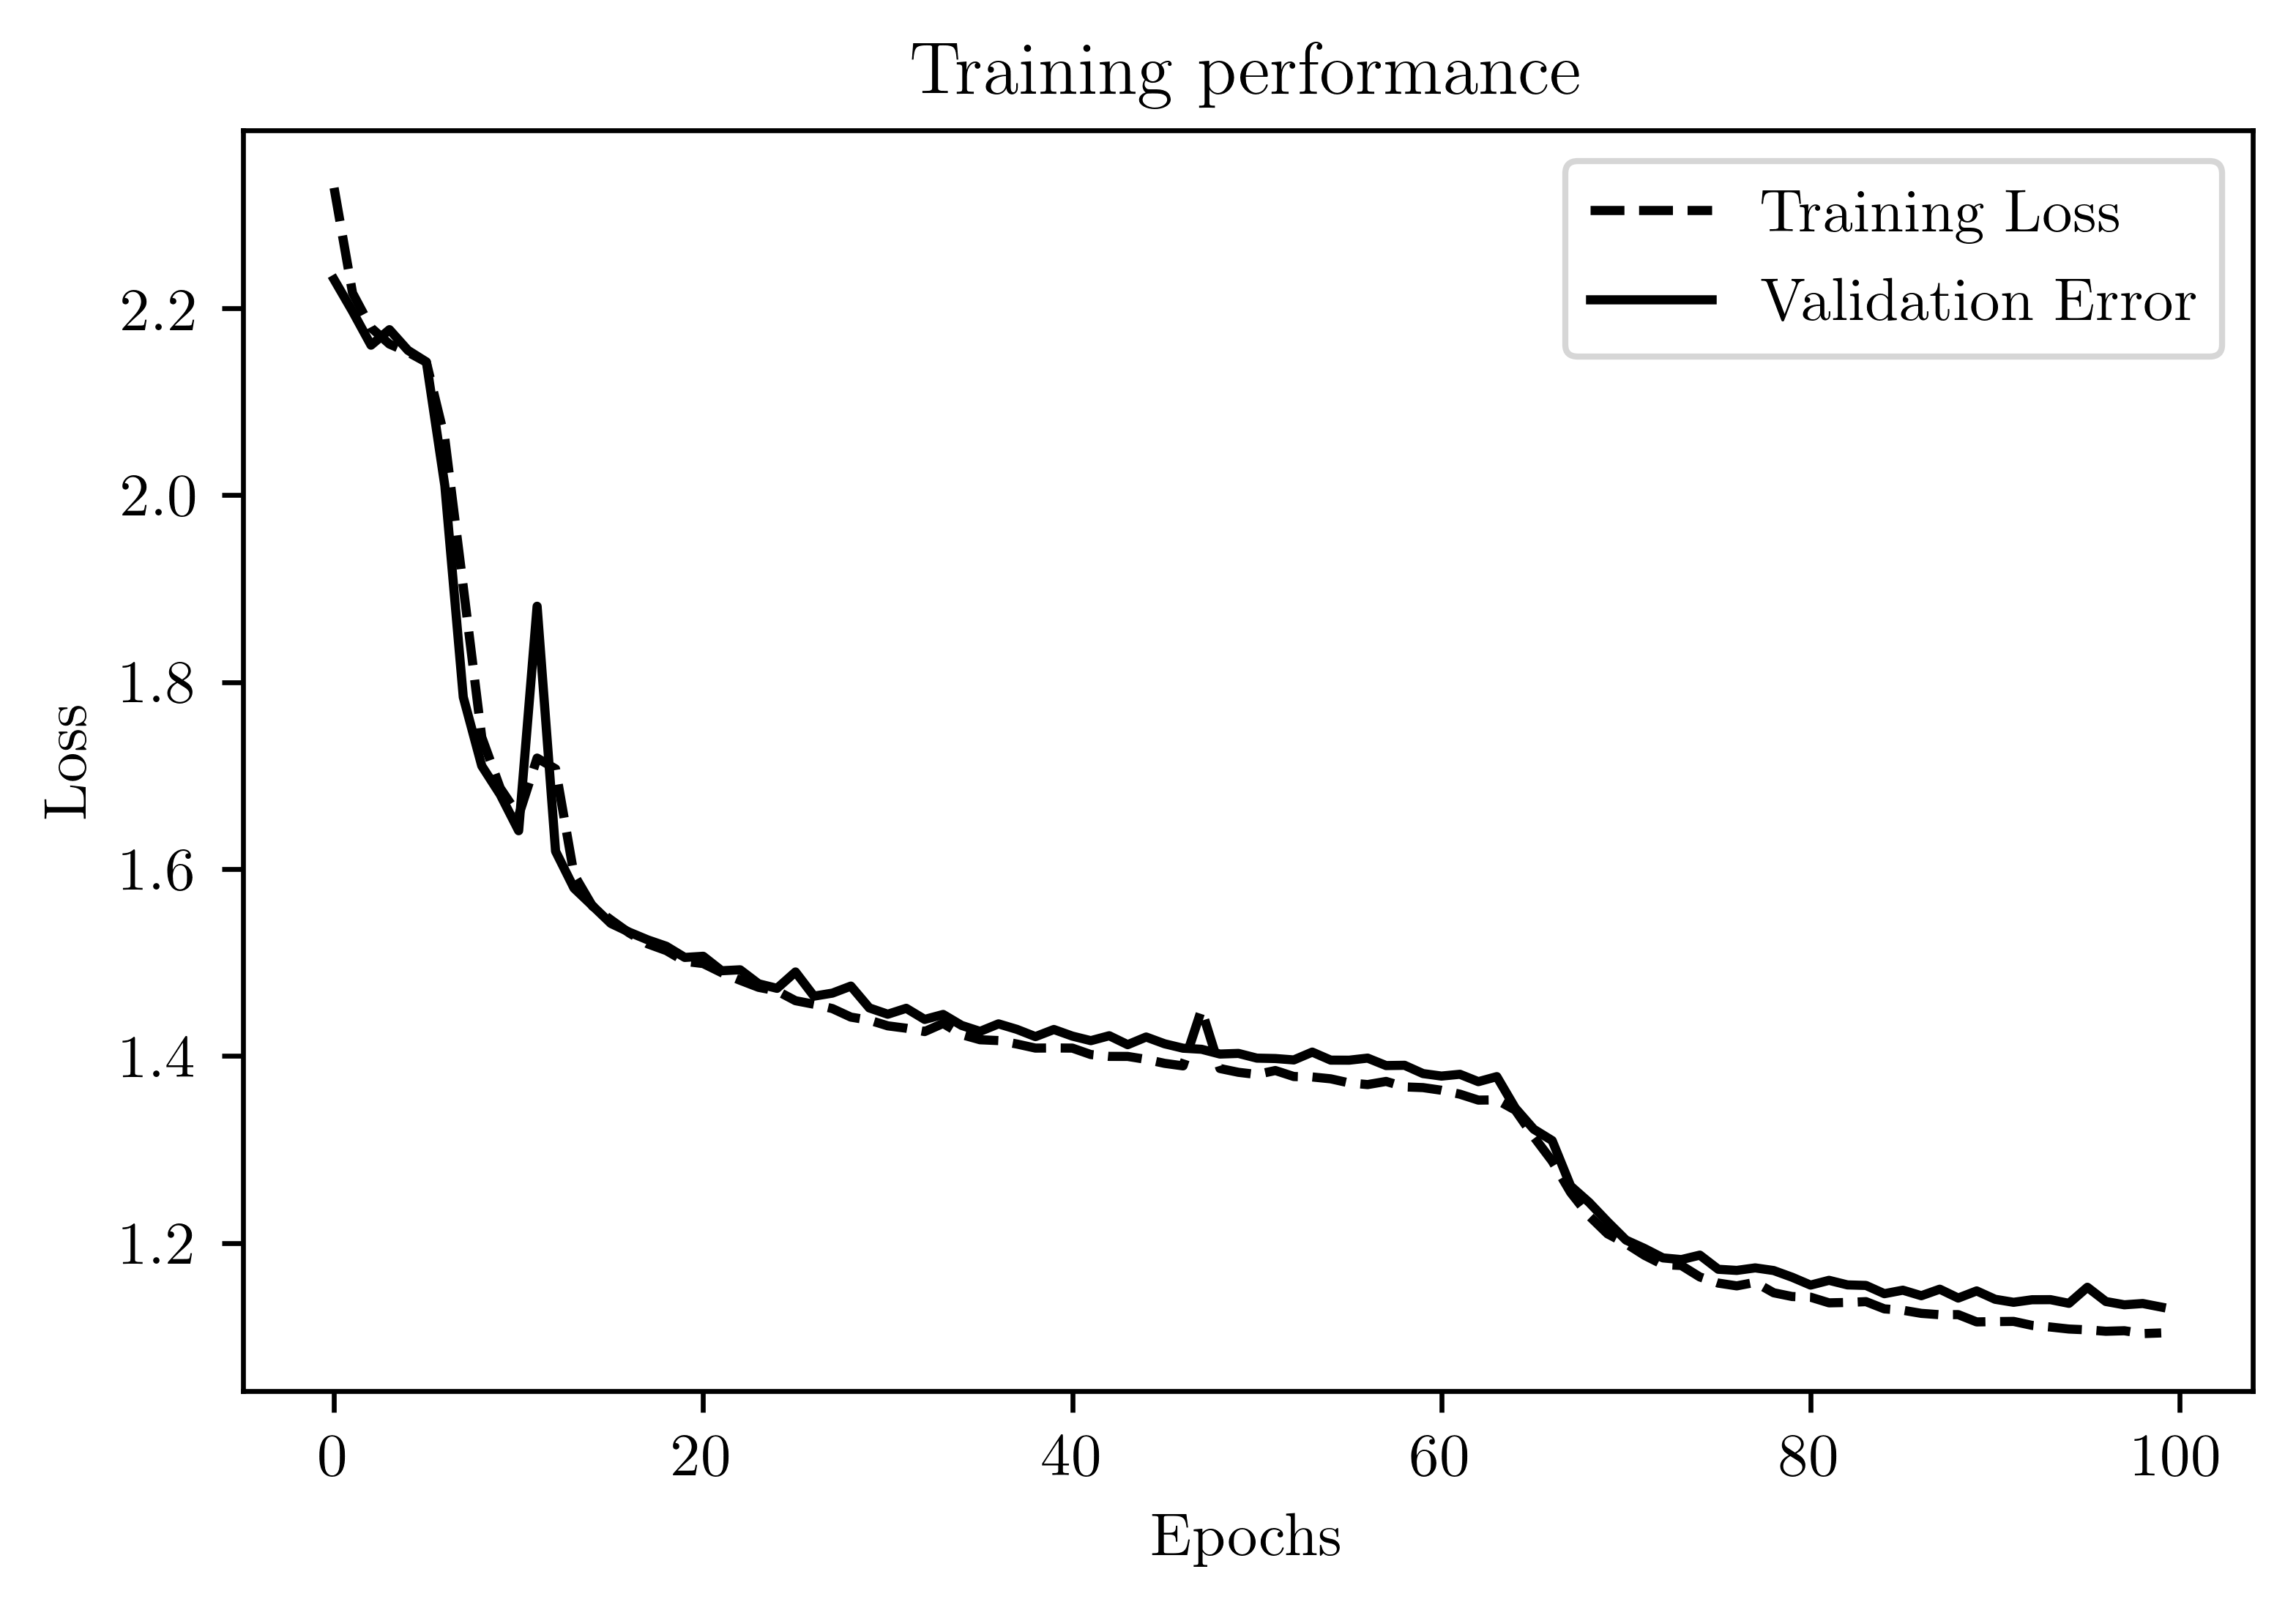

In [ ]:
matplotlib.pyplot.figure(figsize=(textwidth-0.2,3.8), dpi=600)
plt.title('Training performance')
plt.plot(history.epoch,history.history['loss'], linestyle="dashed", color="black", label='Training Loss')
plt.plot(history.epoch,history.history['val_loss'], color="black", label="Validation Error")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("BiLSTM_Train_Validation_Loss.png", bbox_inches="tight")
plt.show()

In [ ]:
test_Y_hat = model.predict(X_test, batch_size=batch_size)


In [ ]:
import time
start = time.perf_counter()
test_Y_hat = model.predict(X_test, batch_size=1024)
end = time.perf_counter()
avg_time = (end - start)/X_test.shape[0]
print("Number of signals: " + str(X_test.shape[0]) )
print("Average time per perdiction: " + str(avg_time * 1e3))
print("Total Time taken: " + str(end-start))

Number of signals: 110000
Average time per perdiction: 0.16193441636363662
Total Time taken: 17.81278580000003


In [ ]:
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[k,j] = conf[k,j] + 1
for i in range(0,len(classes)):
    confnorm[:,i] = conf[:,i] / np.sum(conf[:,i])

(110000, 128, 2)


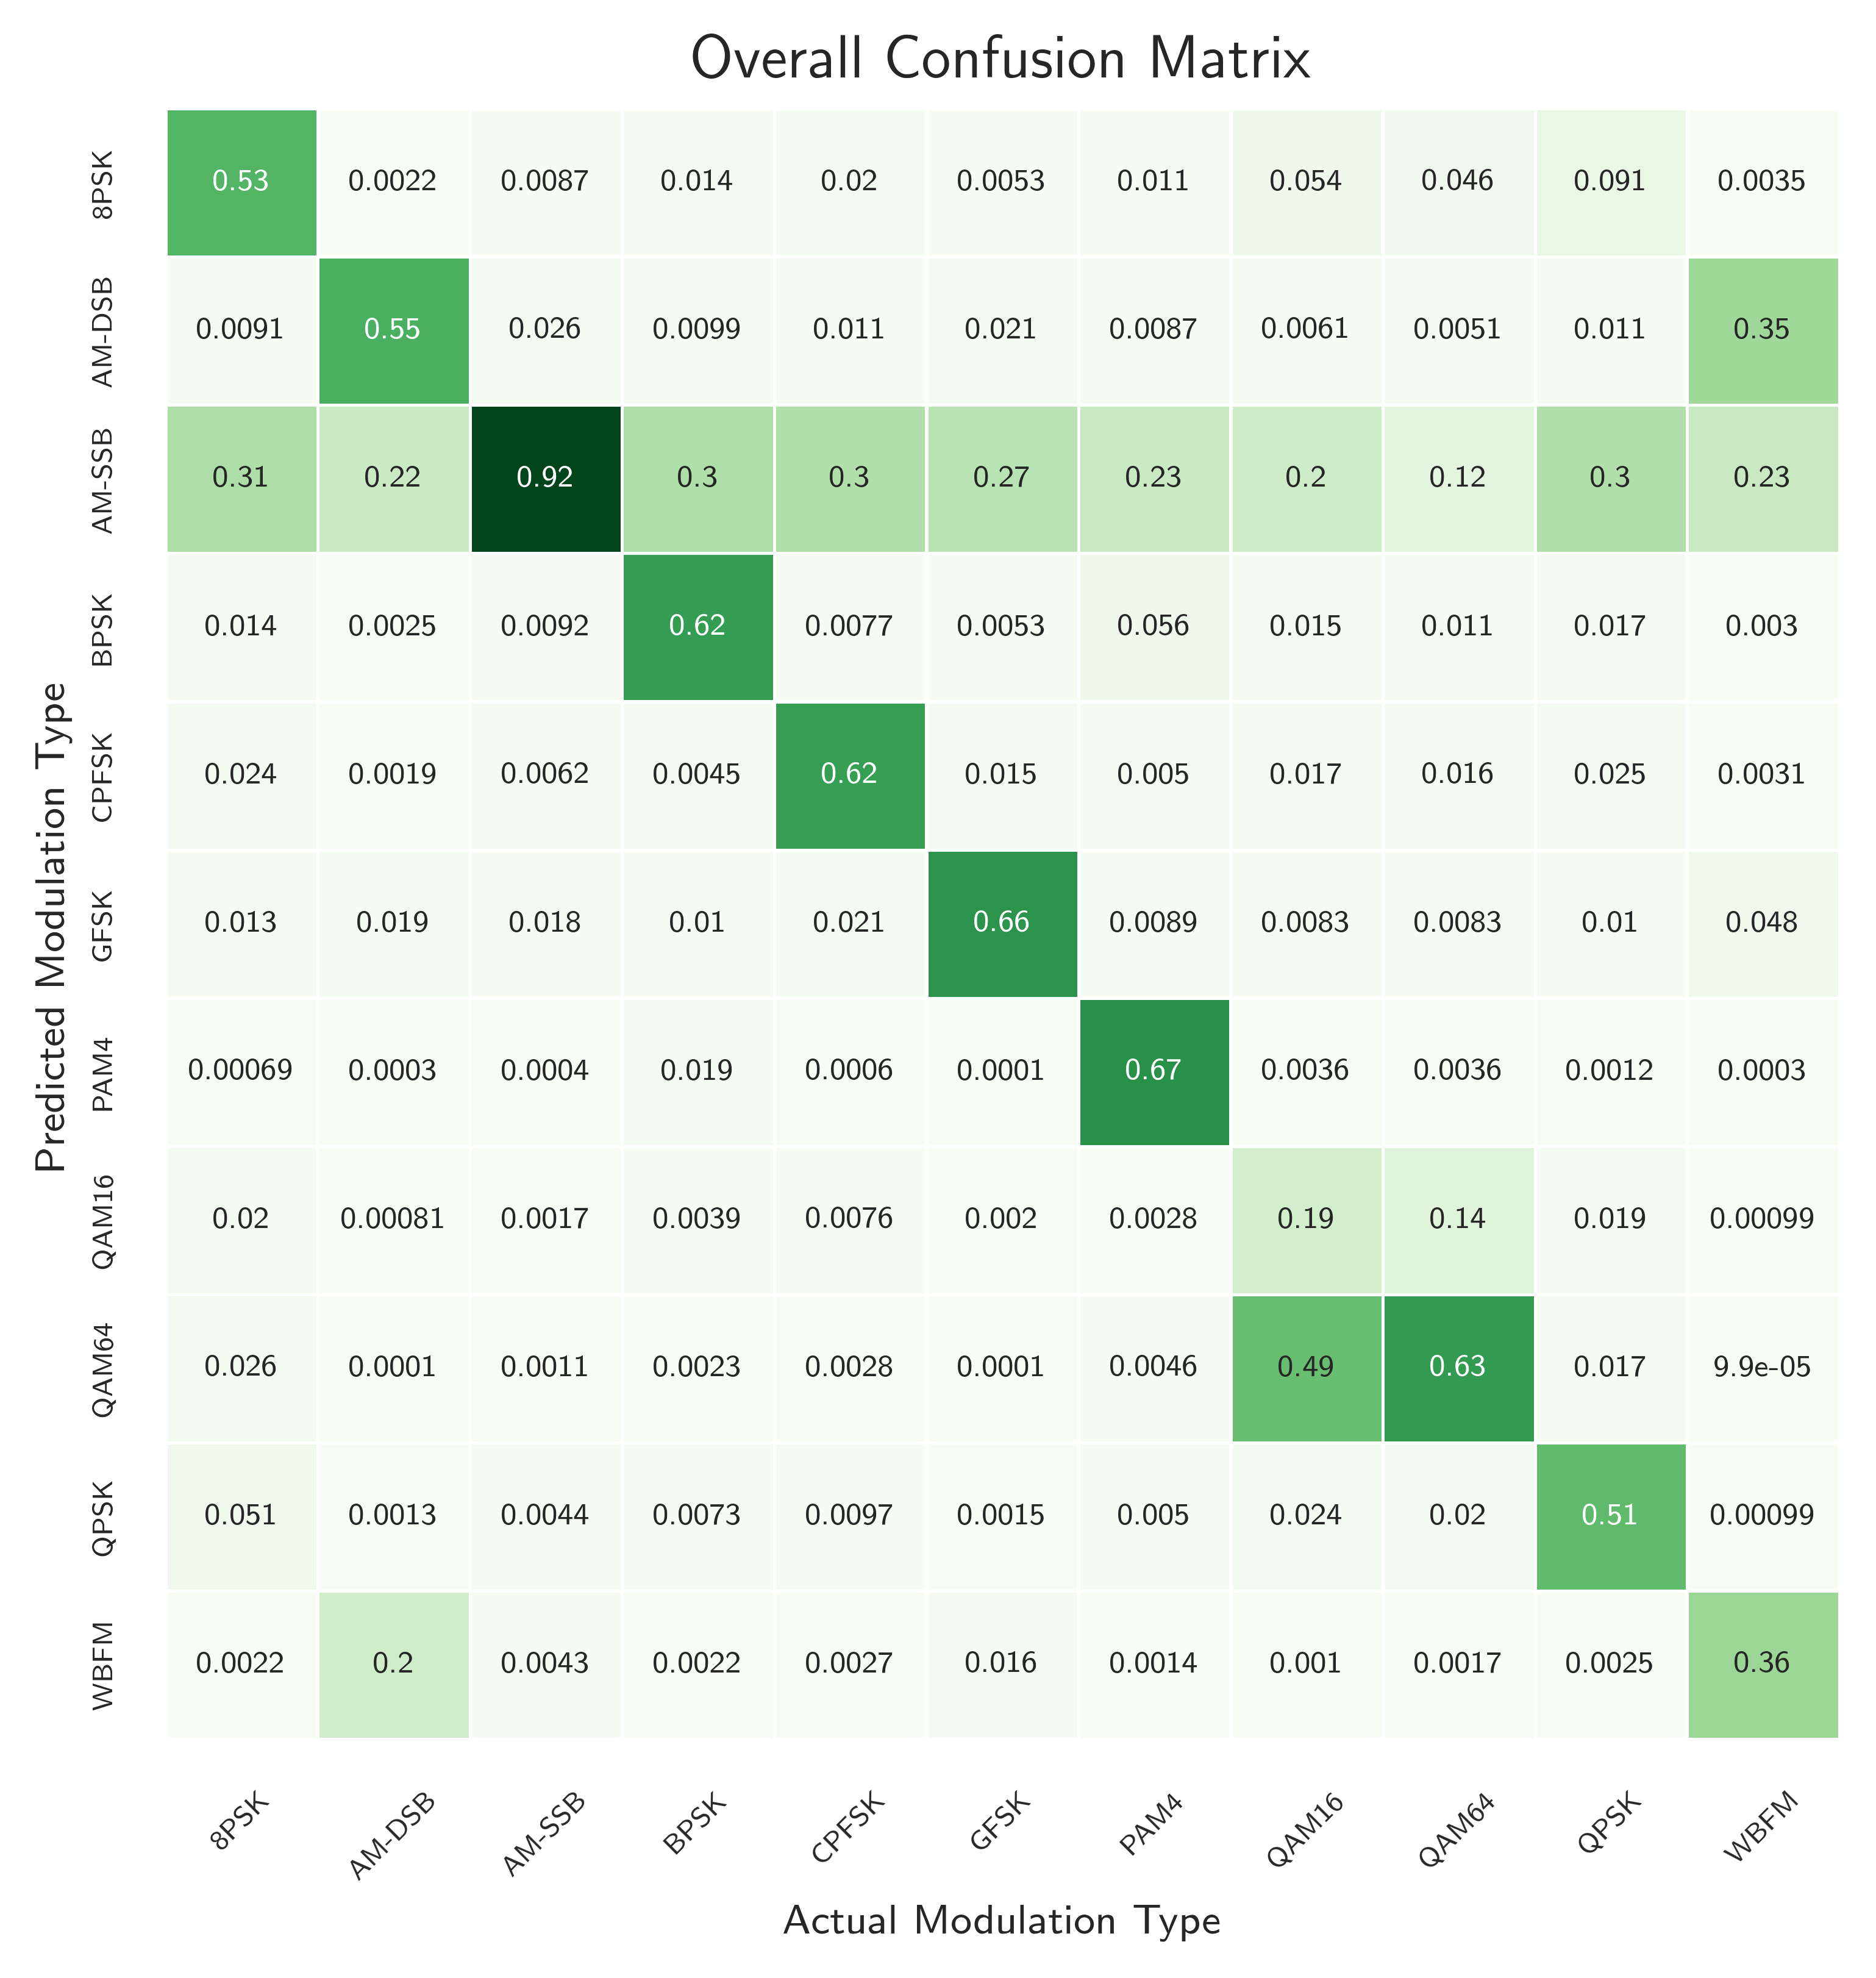

In [ ]:
print(X_test.shape)
#plt.figure(figsize=(7, 7), dpi=80)
matplotlib.pyplot.figure(figsize=(textwidth-0.2,textwidth-0.2), dpi=600)
sn.set(rc={'figure.figsize':(textwidth,3.8), 'text.usetex' : True })
sn.set(font_scale=0.5) # for label size
ax = sn.heatmap(confnorm, annot=True, cmap="Greens", xticklabels=classes, yticklabels=classes, linewidths=0.5, cbar=False)
ax.set_xticklabels(classes,rotation=45)
ax.set_xlabel("Actual Modulation Type", fontsize="8")
ax.set_ylabel("Predicted Modulation Type", fontsize="8")
ax.set_title("Overall Confusion Matrix", fontsize="12")
#plot_confusion_matrix(confnorm, labels=classes)
fig = ax.get_figure()
fig.savefig("ALSTM_Overall_CM.png", bbox_inches="tight")

In [ ]:
def plot_small_confusion(title, data, classes, filename="" ):
  matplotlib.pyplot.figure(figsize=(textwidth/2.3,textwidth/2.3), dpi=600)
  sn.set(rc={'figure.figsize':(textwidth,3.8), 'text.usetex' : True })
  sn.set(font_scale=0.3) # for label size
  ax = sn.heatmap(confnorm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes, linewidths=0.5, cbar=False)
  ax.set_xticklabels(classes,rotation=45)
  #ax.set_xlabel("Actual Modulation Type", fontsize="8")
  #ax.set_ylabel("Predicted Modulation Type", fontsize="8")
  ax.set_title(title, fontsize="12")
  #plot_confusion_matrix(confnorm, labels=classes)
  fig = ax.get_figure()
  fig.savefig(filename, bbox_inches="tight")

Overall Accuracy:  0.09551692589204025
Overall Accuracy:  0.09173478655767484
Overall Accuracy:  0.09949348769898697
Overall Accuracy:  0.11692529772645255
Overall Accuracy:  0.1626253418413856
Overall Accuracy:  0.2544872934067887
Overall Accuracy:  0.3746095902994672
Overall Accuracy:  0.5289589442815249
Overall Accuracy:  0.6536044362292052
Overall Accuracy:  0.7206095791001451
Overall Accuracy:  0.7815693430656935
Overall Accuracy:  0.8093420574336605
Overall Accuracy:  0.8256240822320118
Overall Accuracy:  0.8389891696750903
Overall Accuracy:  0.8387736699729486
Overall Accuracy:  0.8438979963570128
Overall Accuracy:  0.8348723519826181
Overall Accuracy:  0.8422218121424617
Overall Accuracy:  0.8280542986425339
Overall Accuracy:  0.8412241224122412


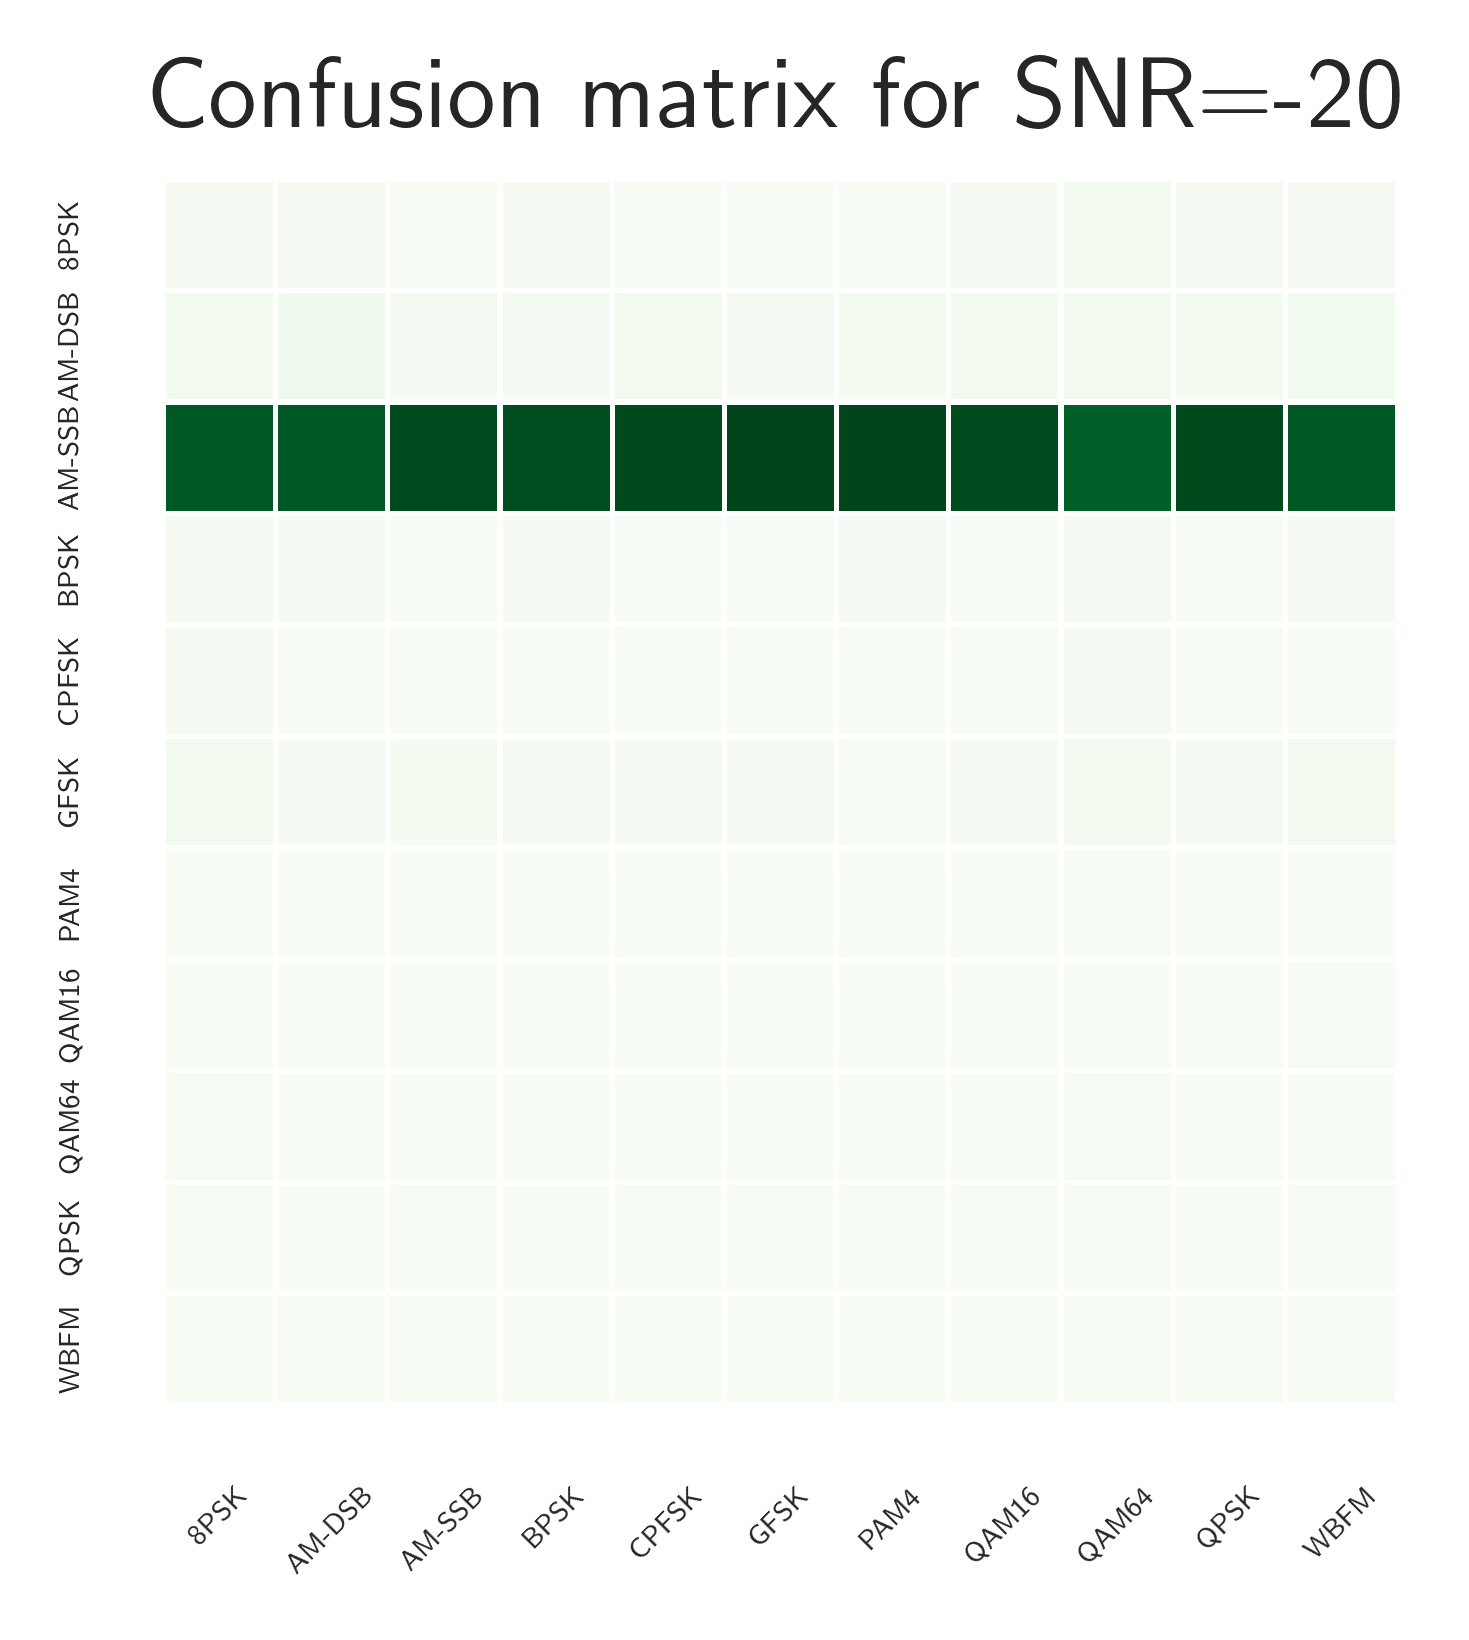

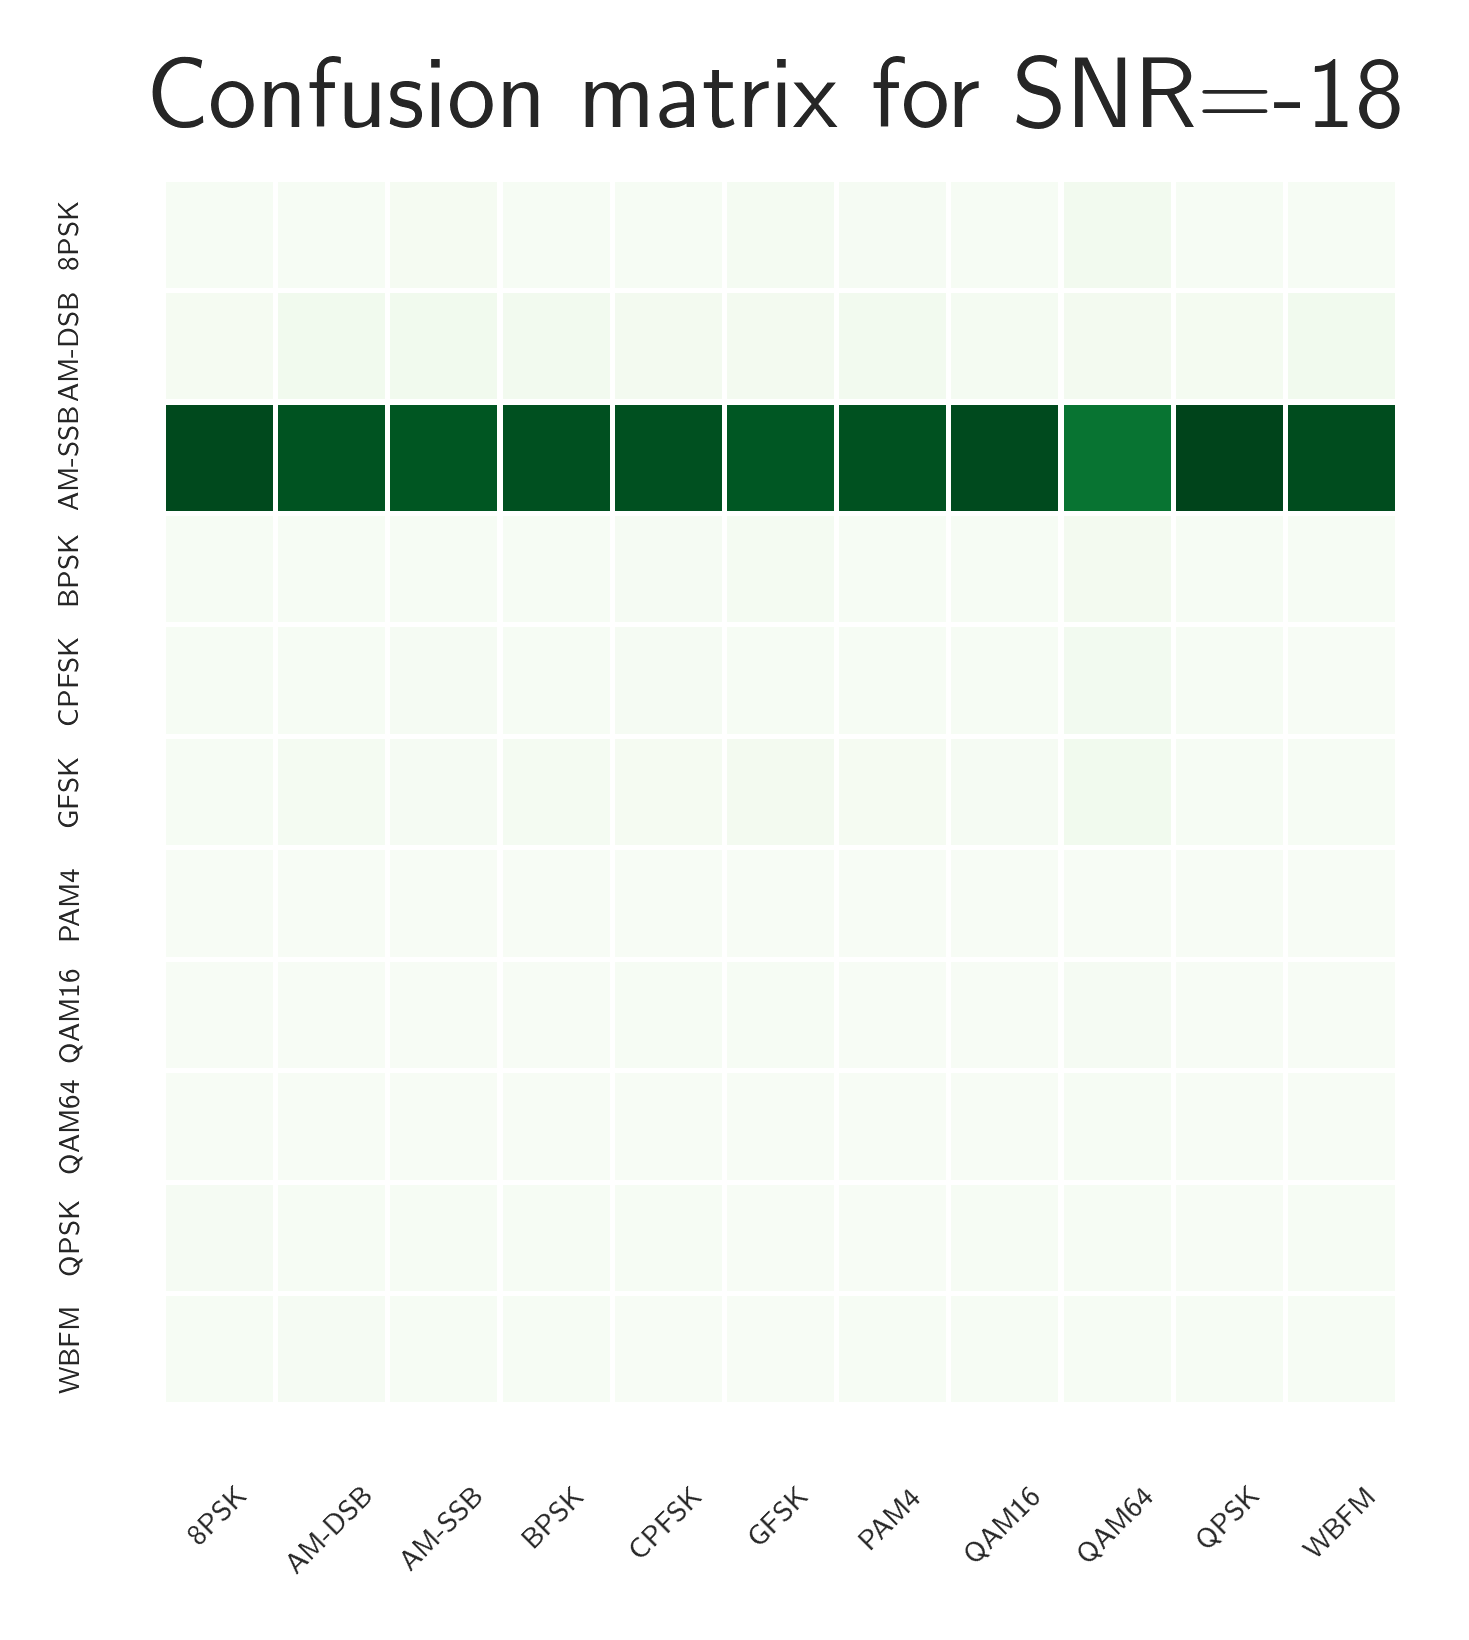

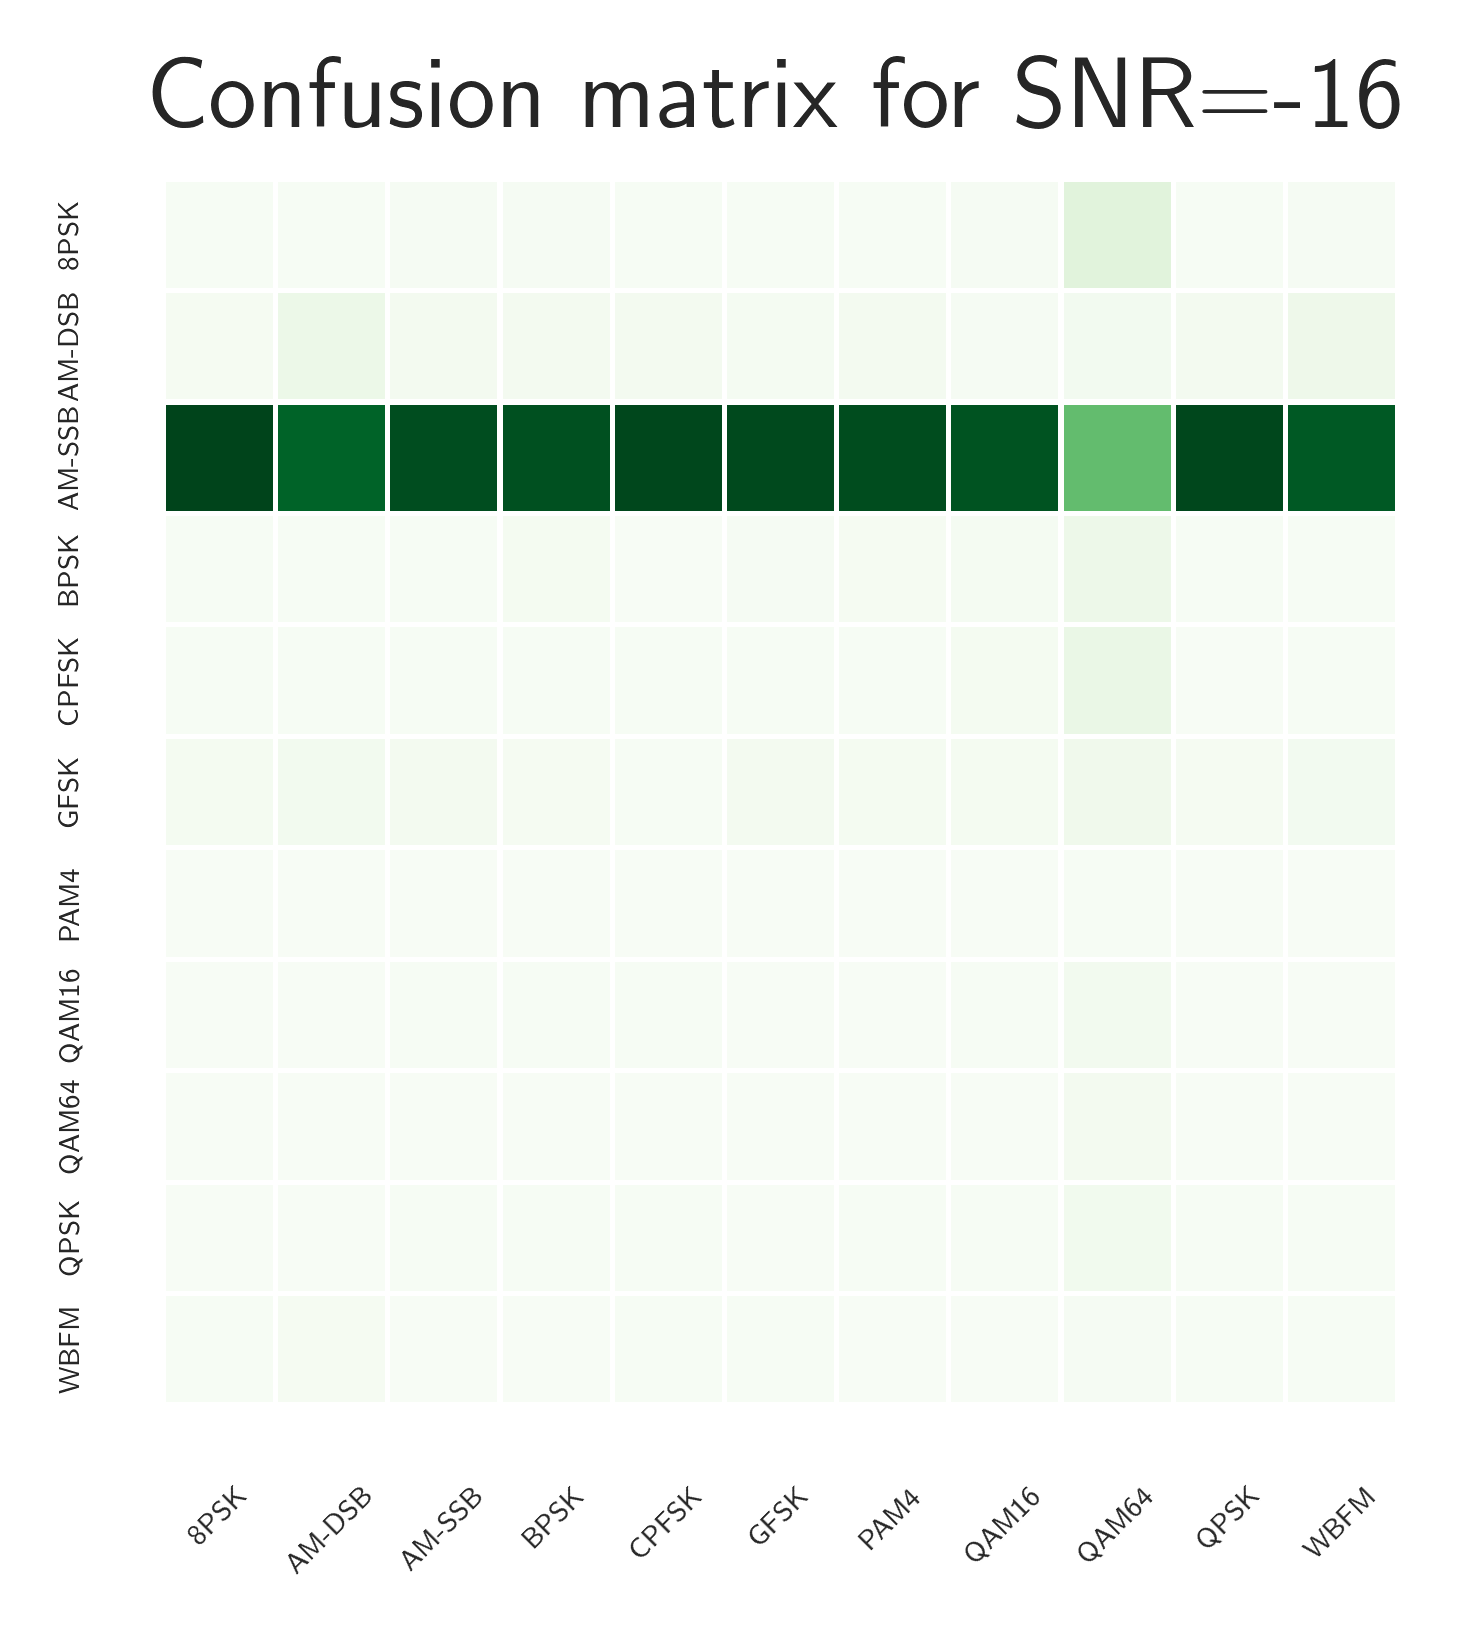

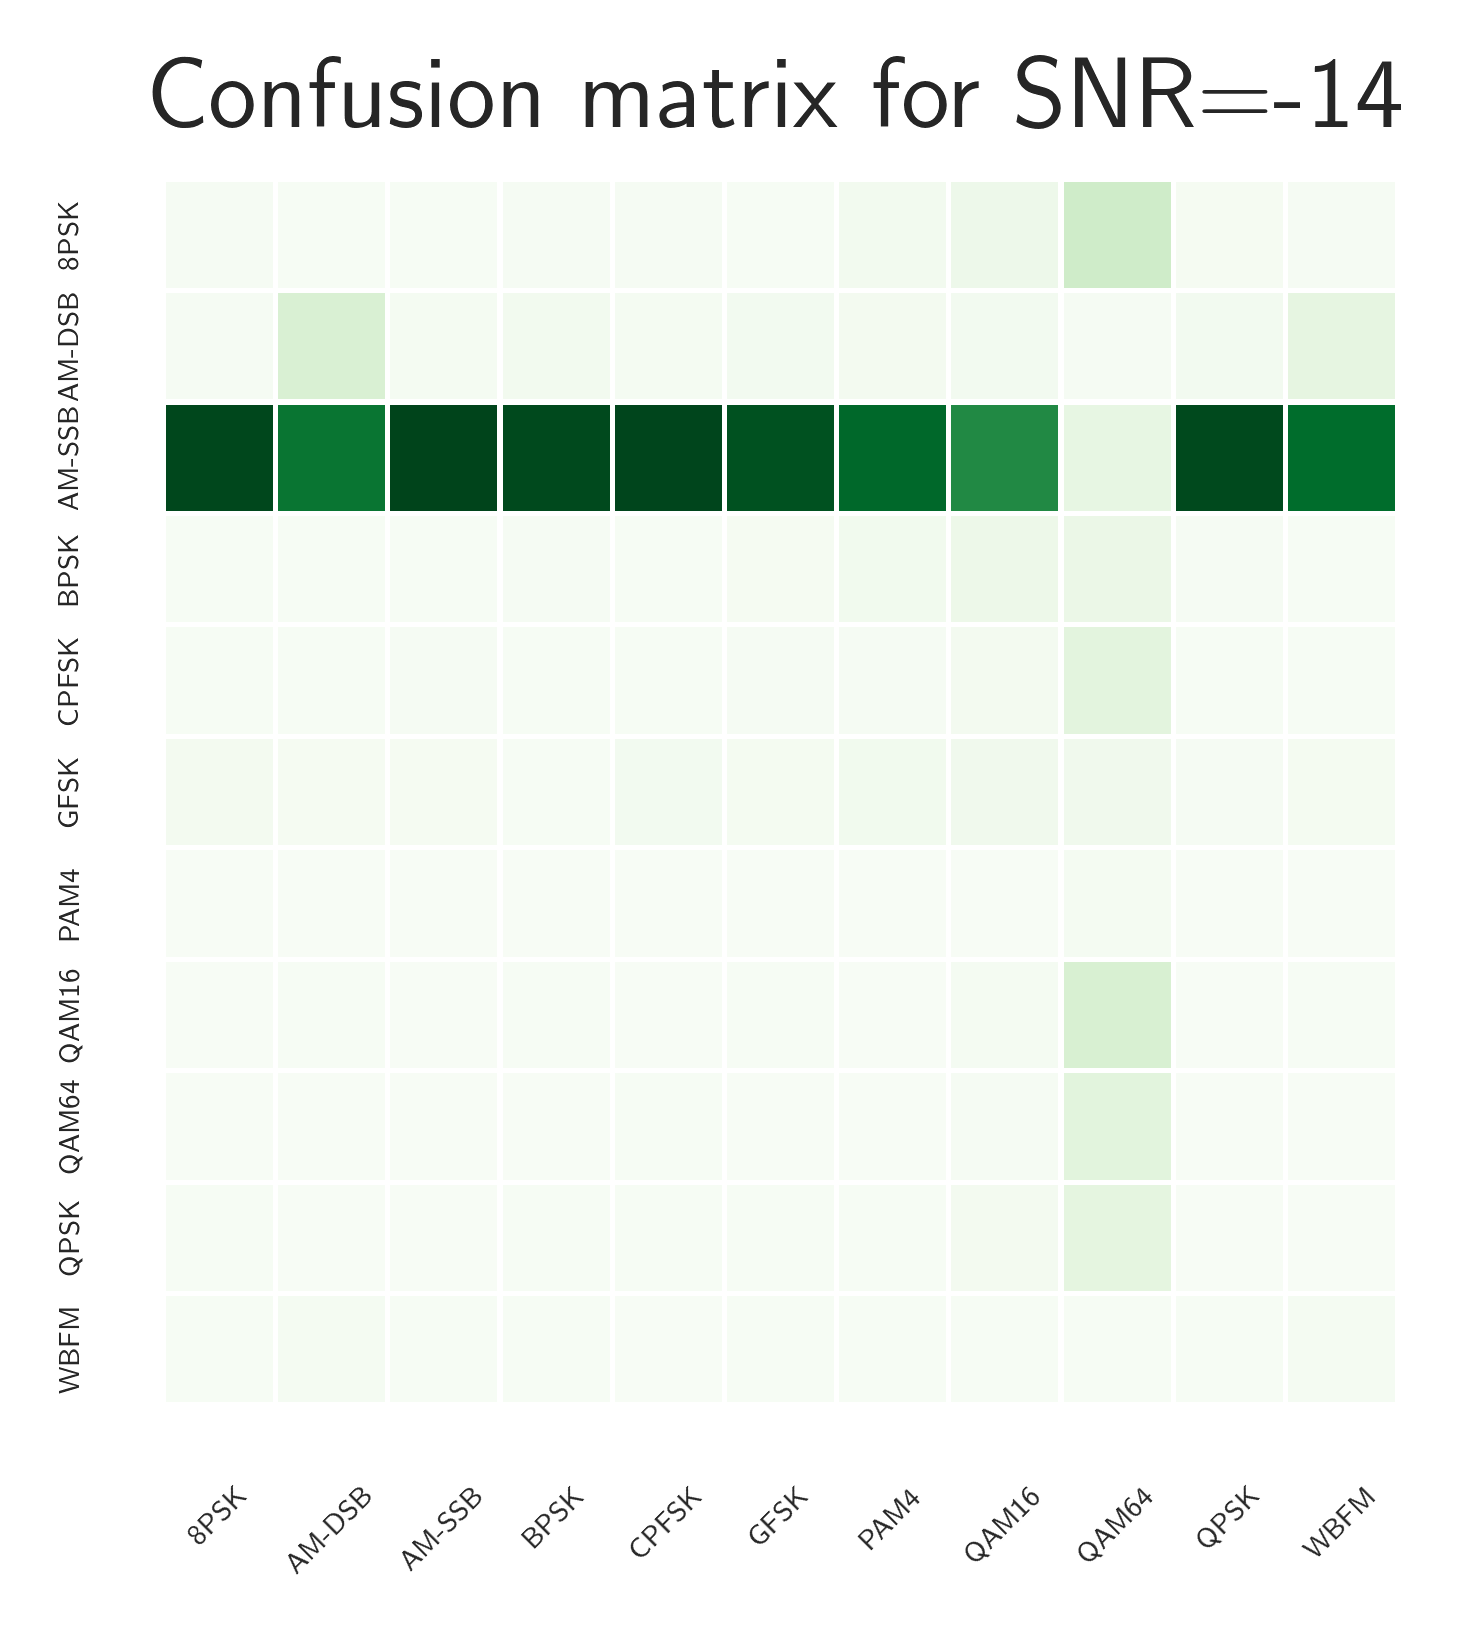

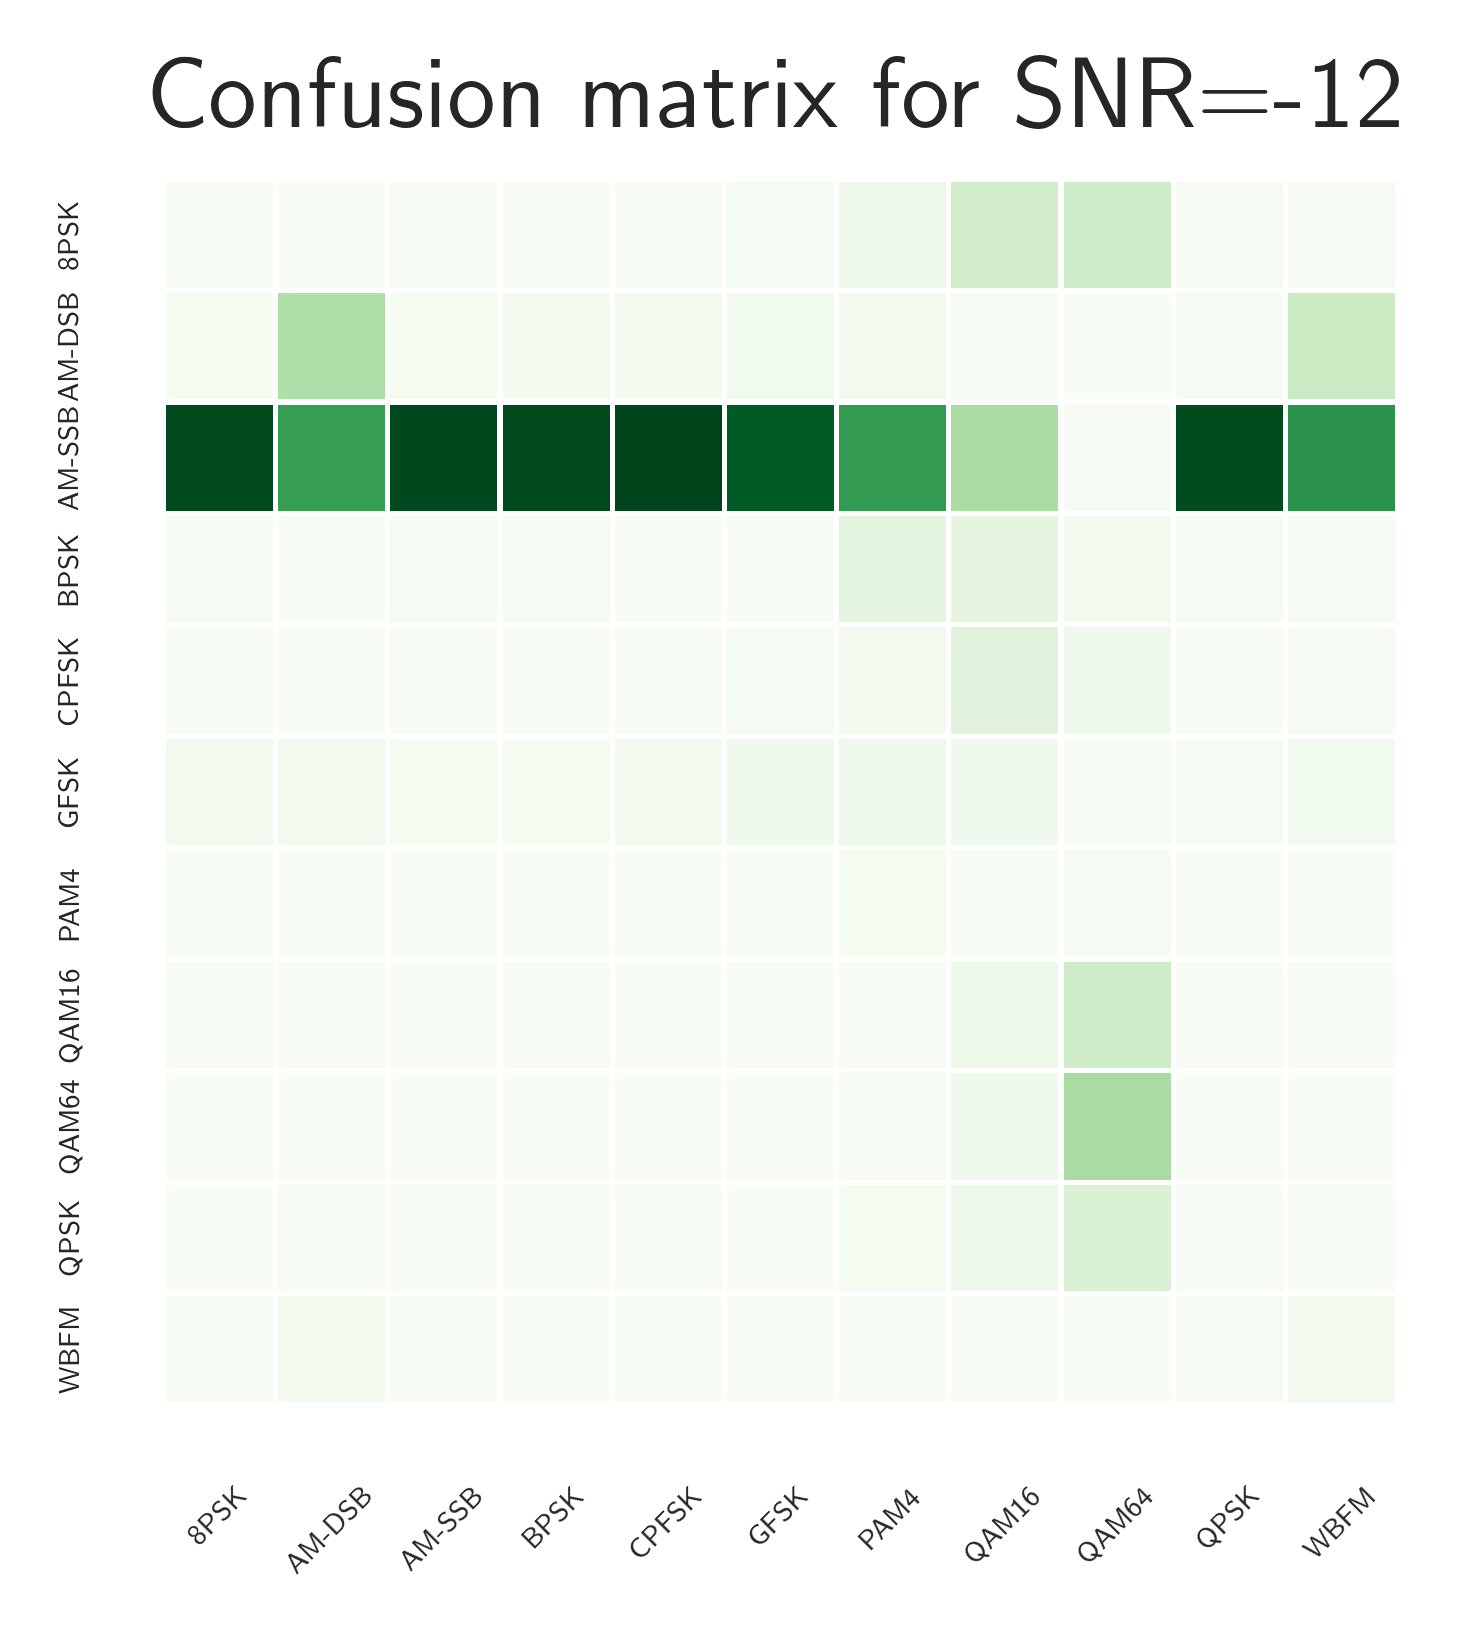

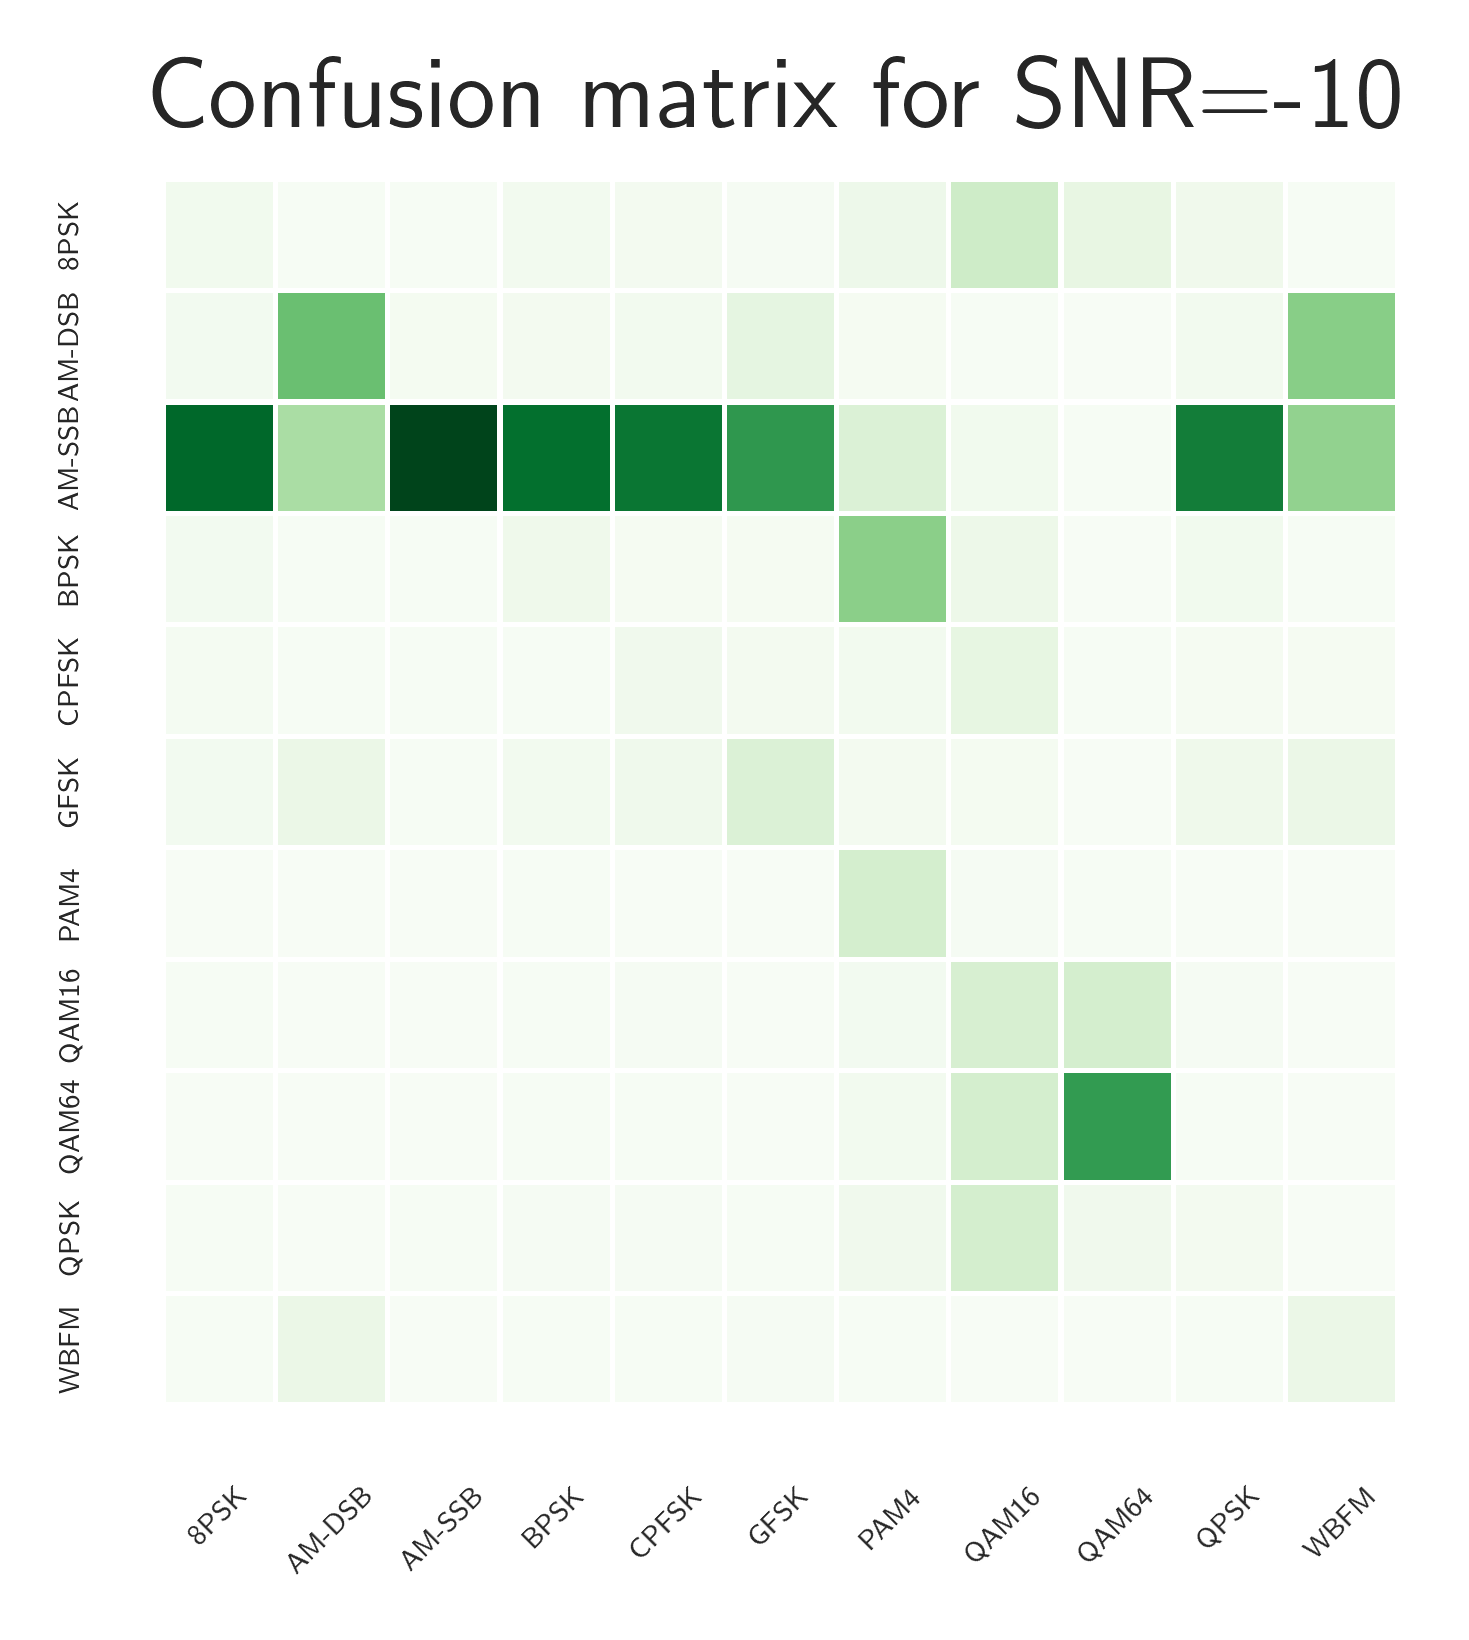

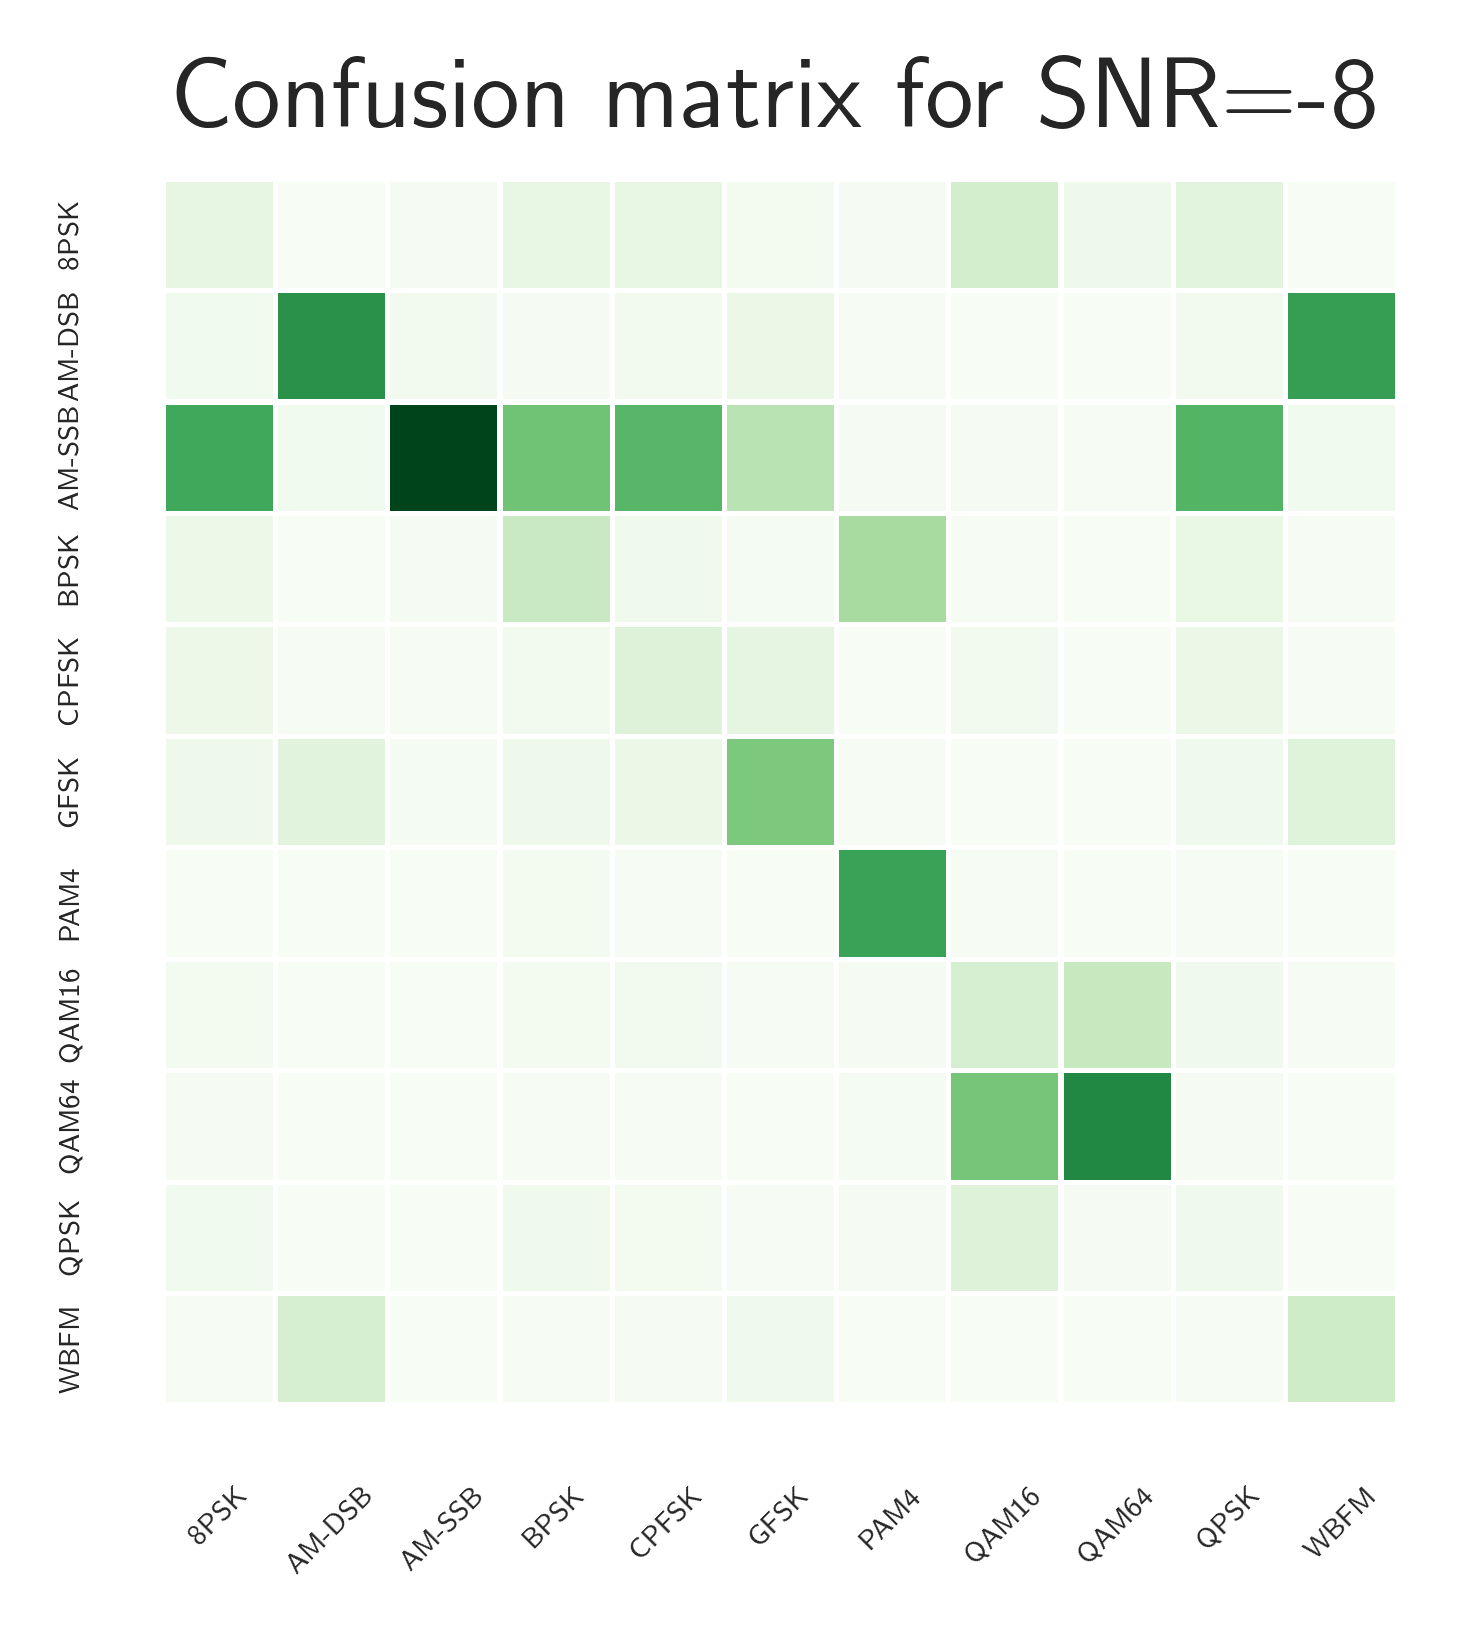

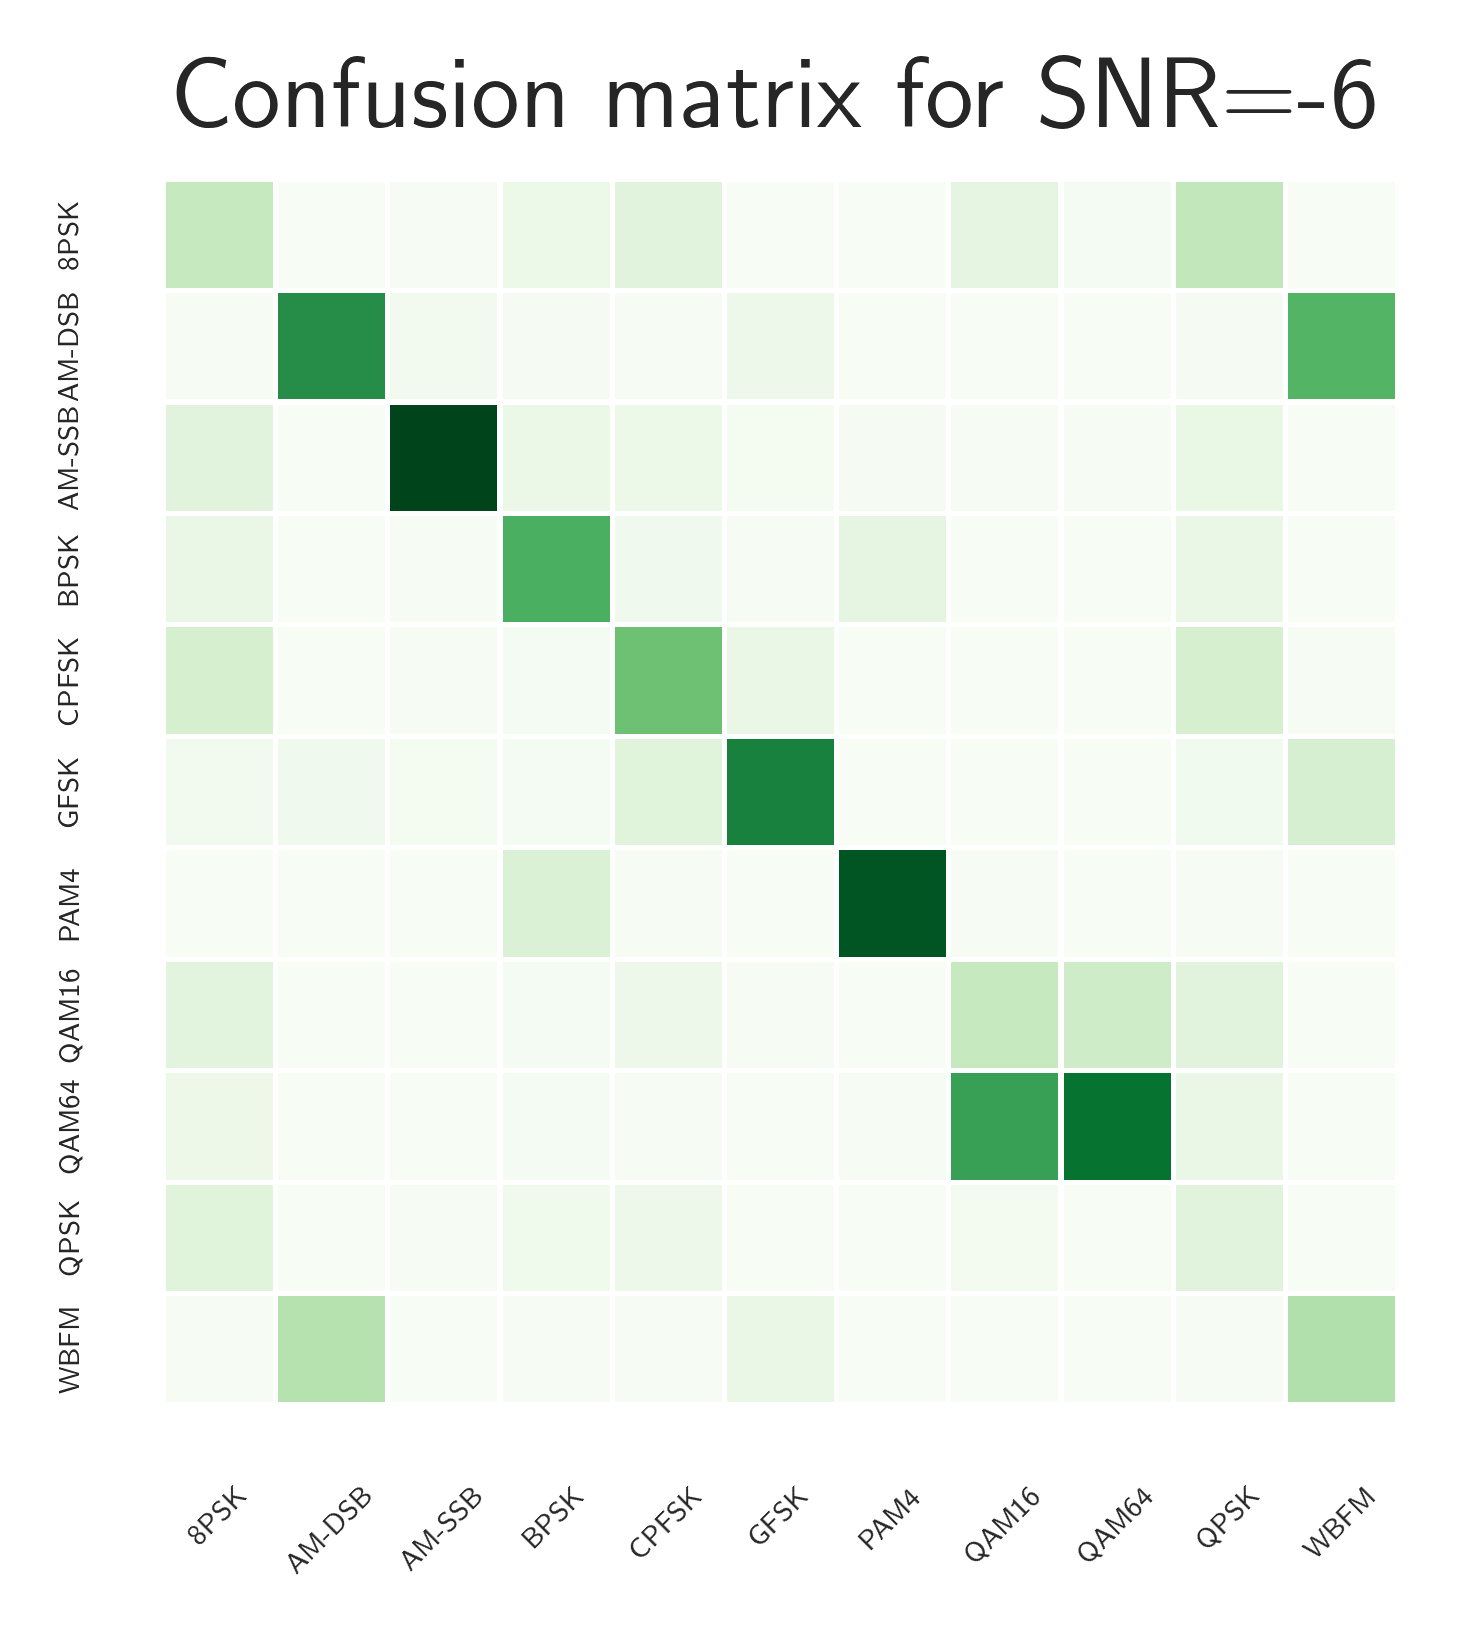

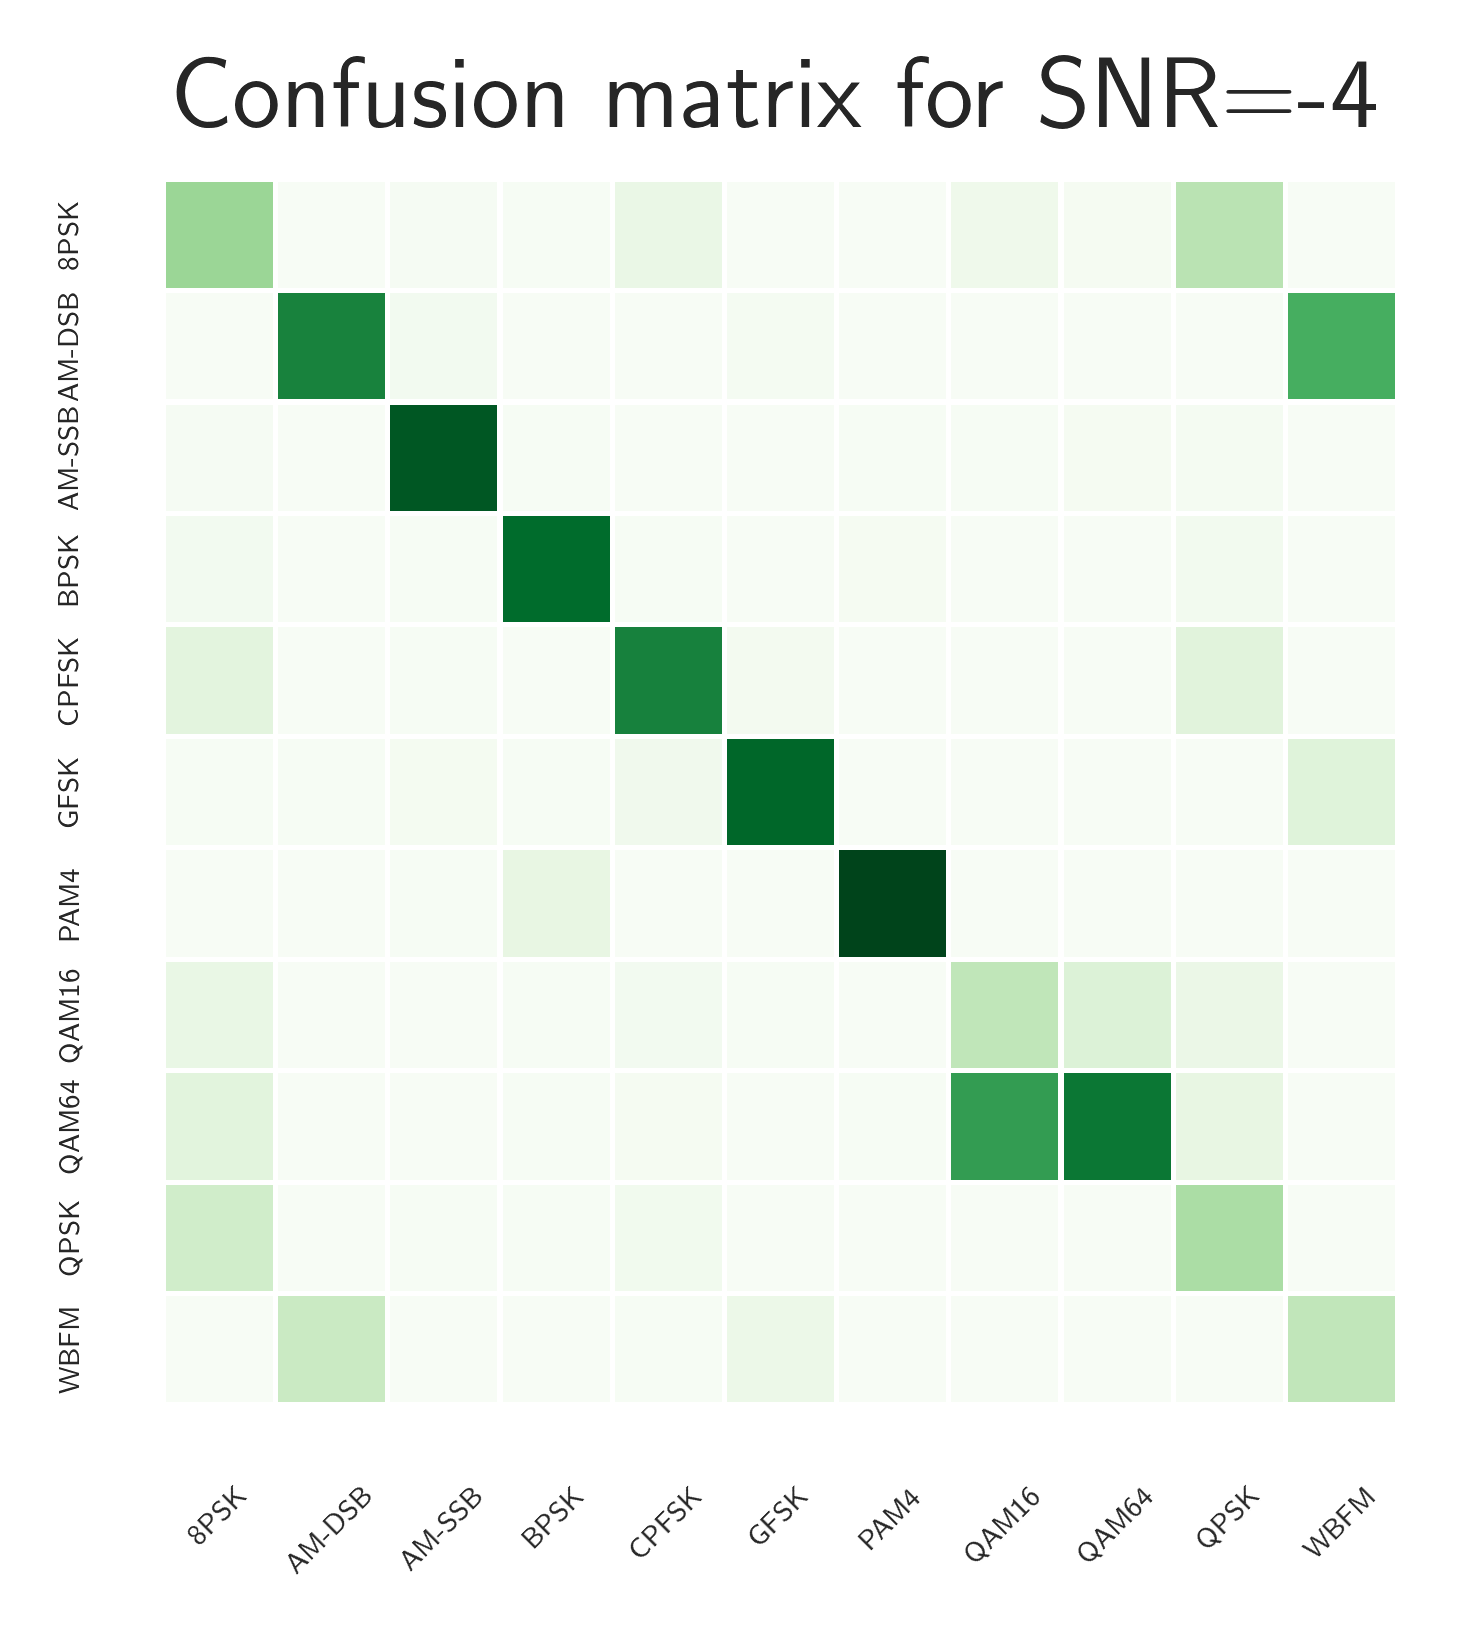

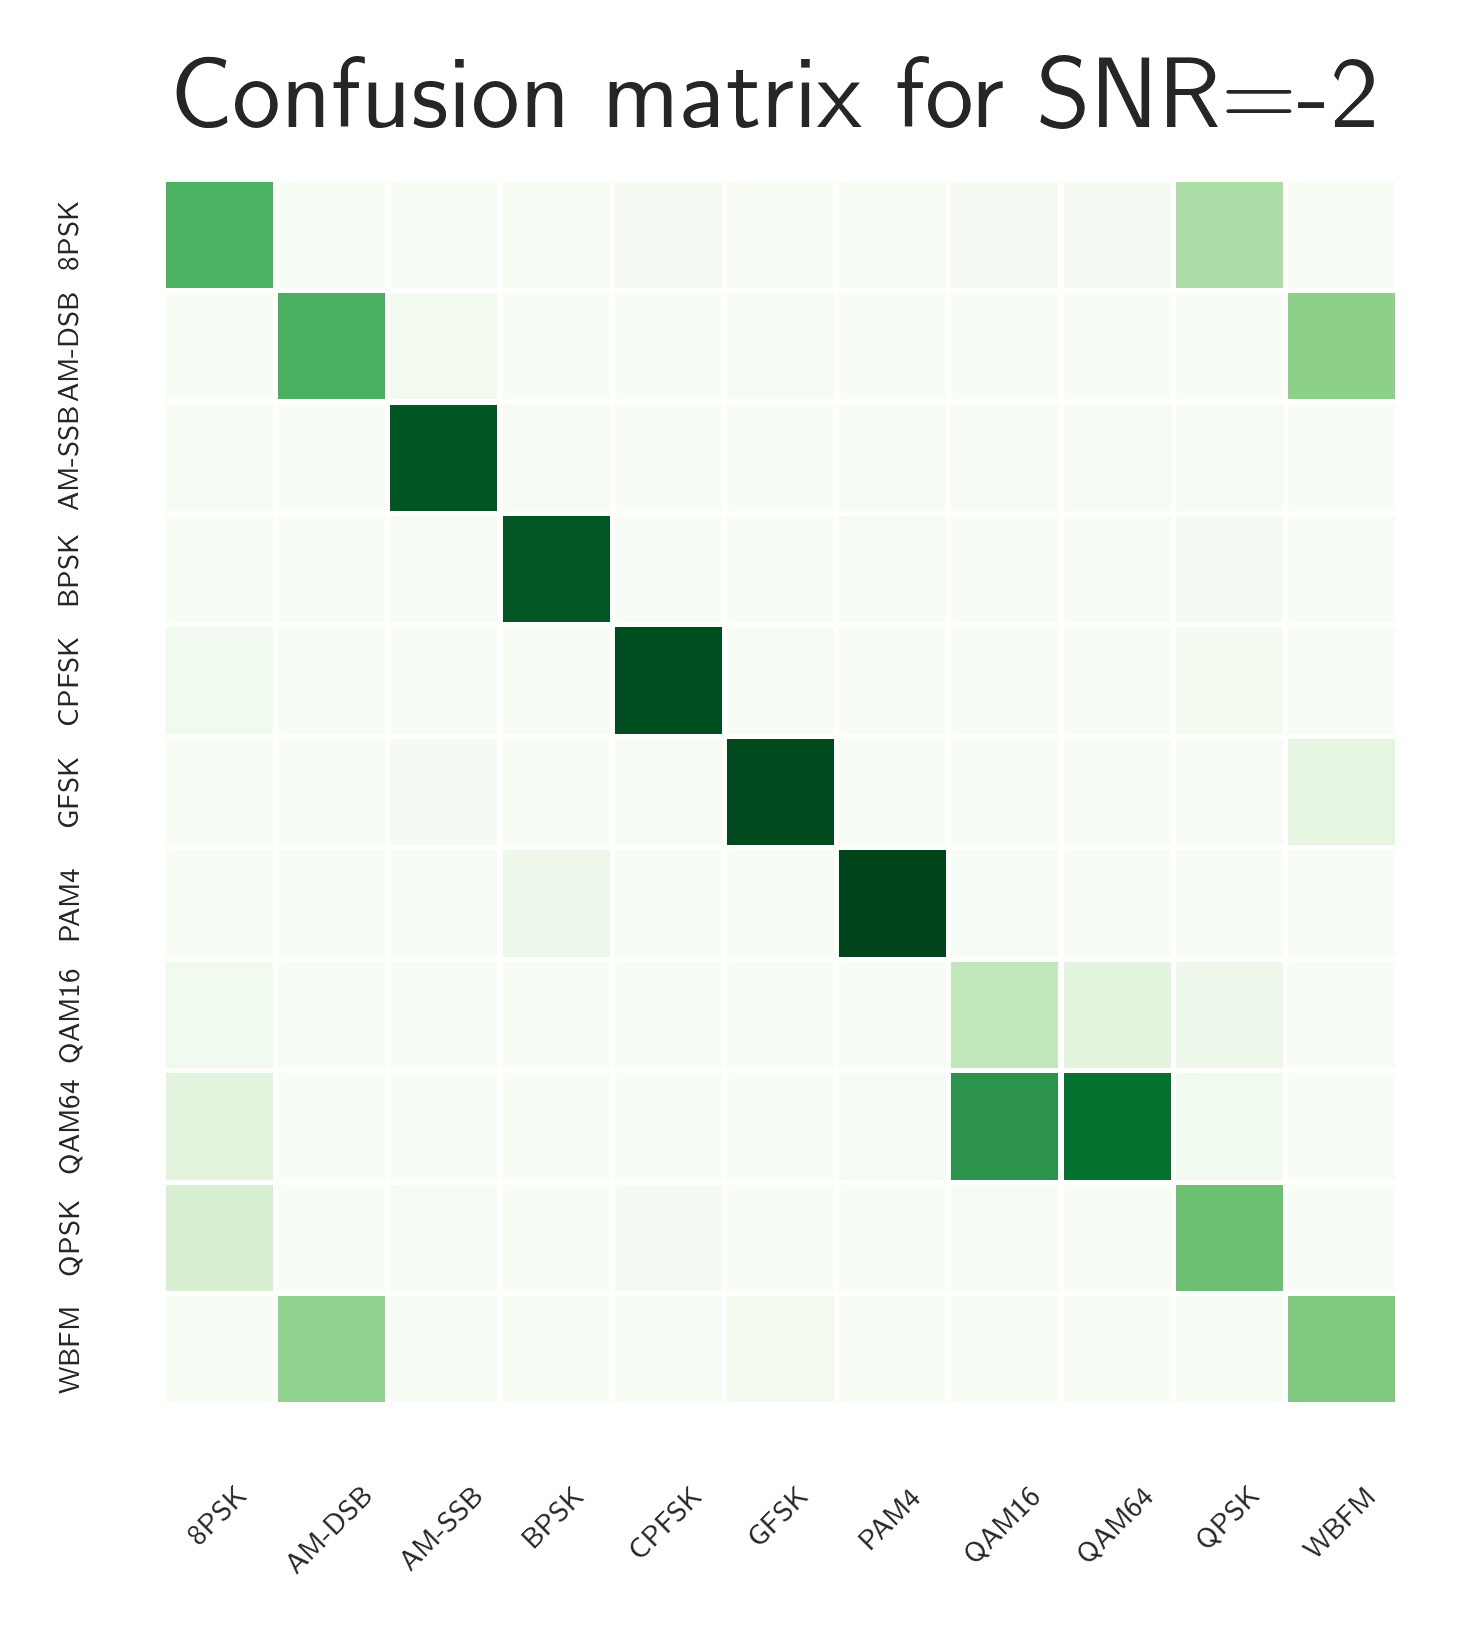

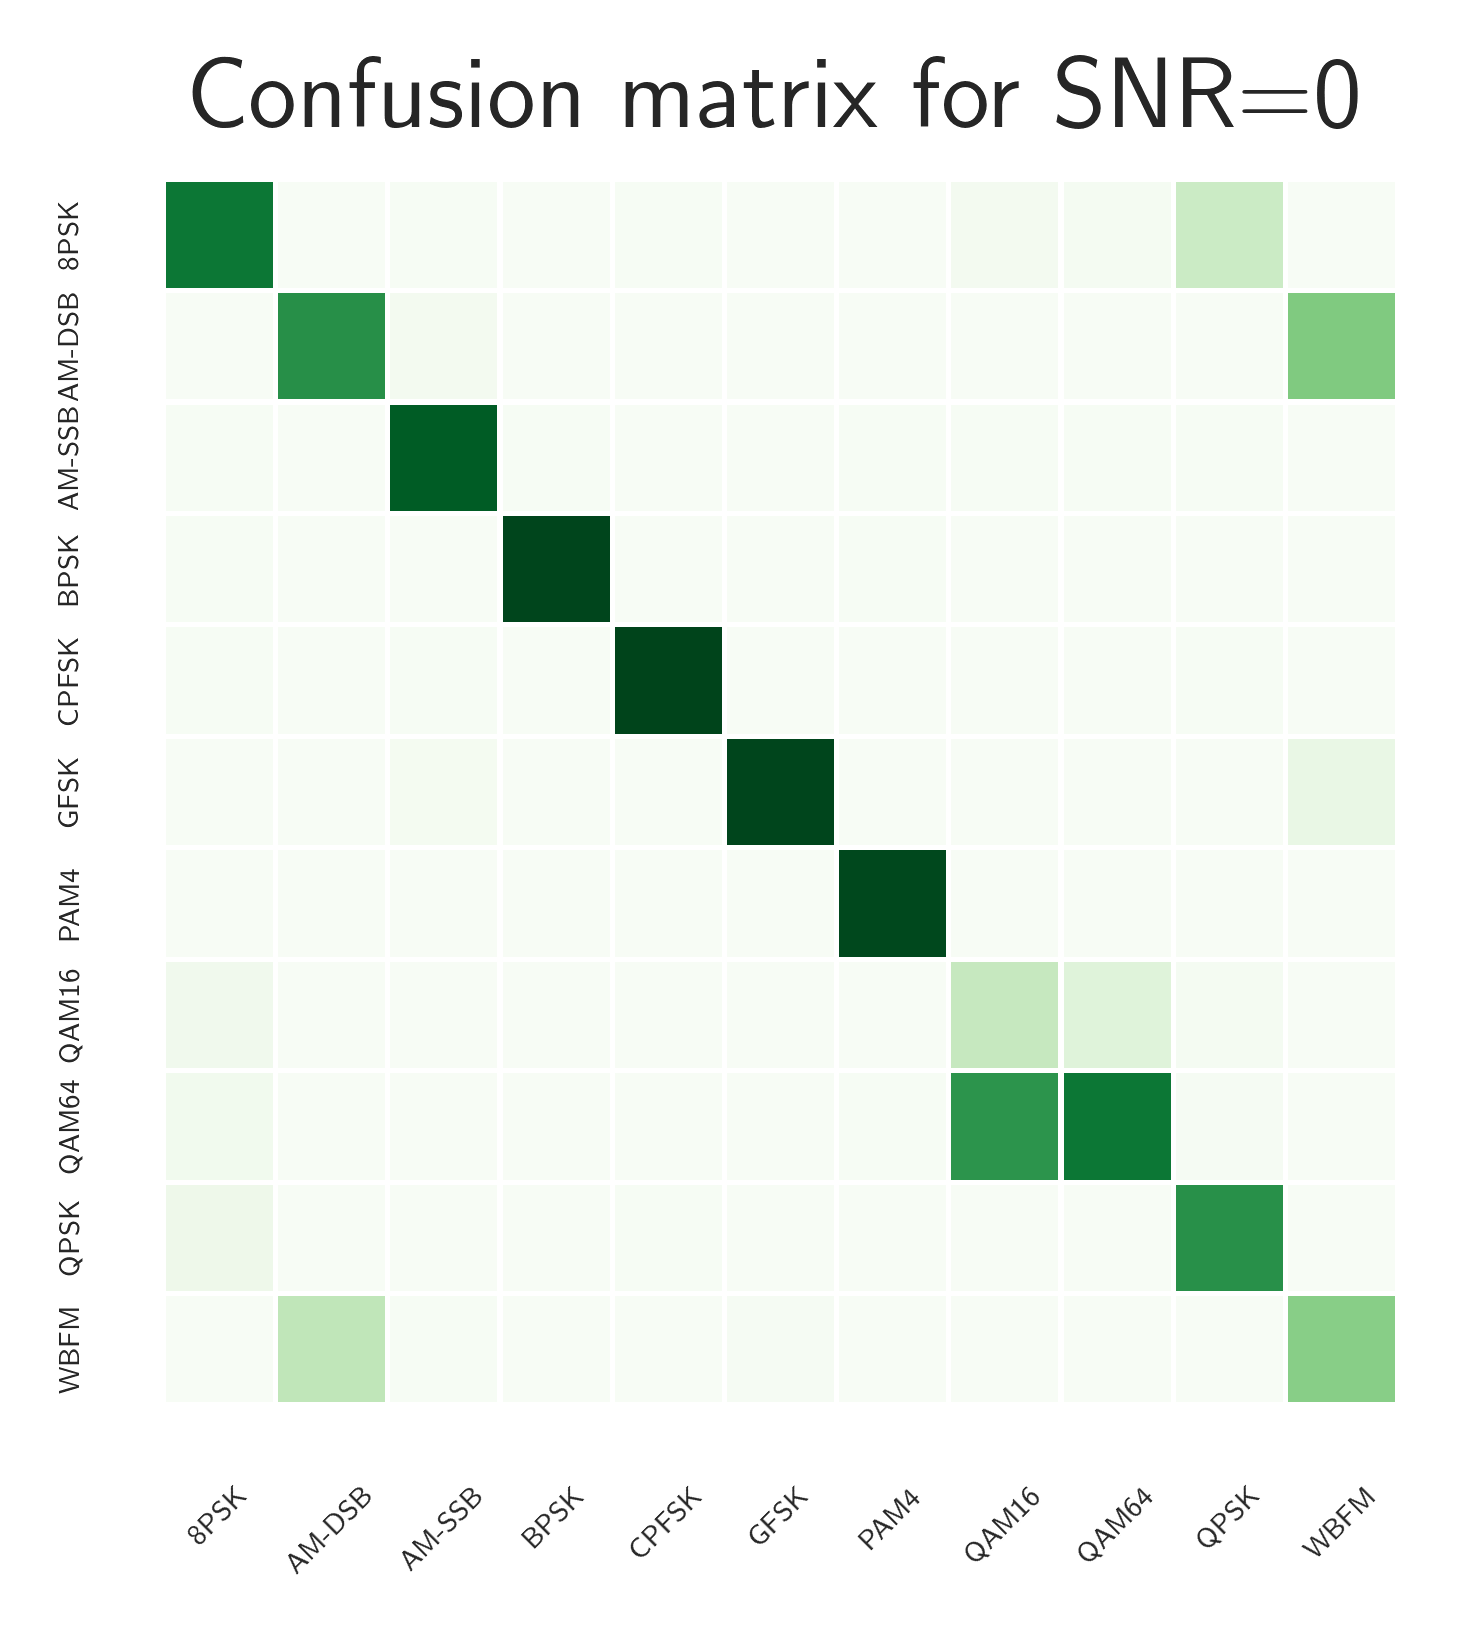

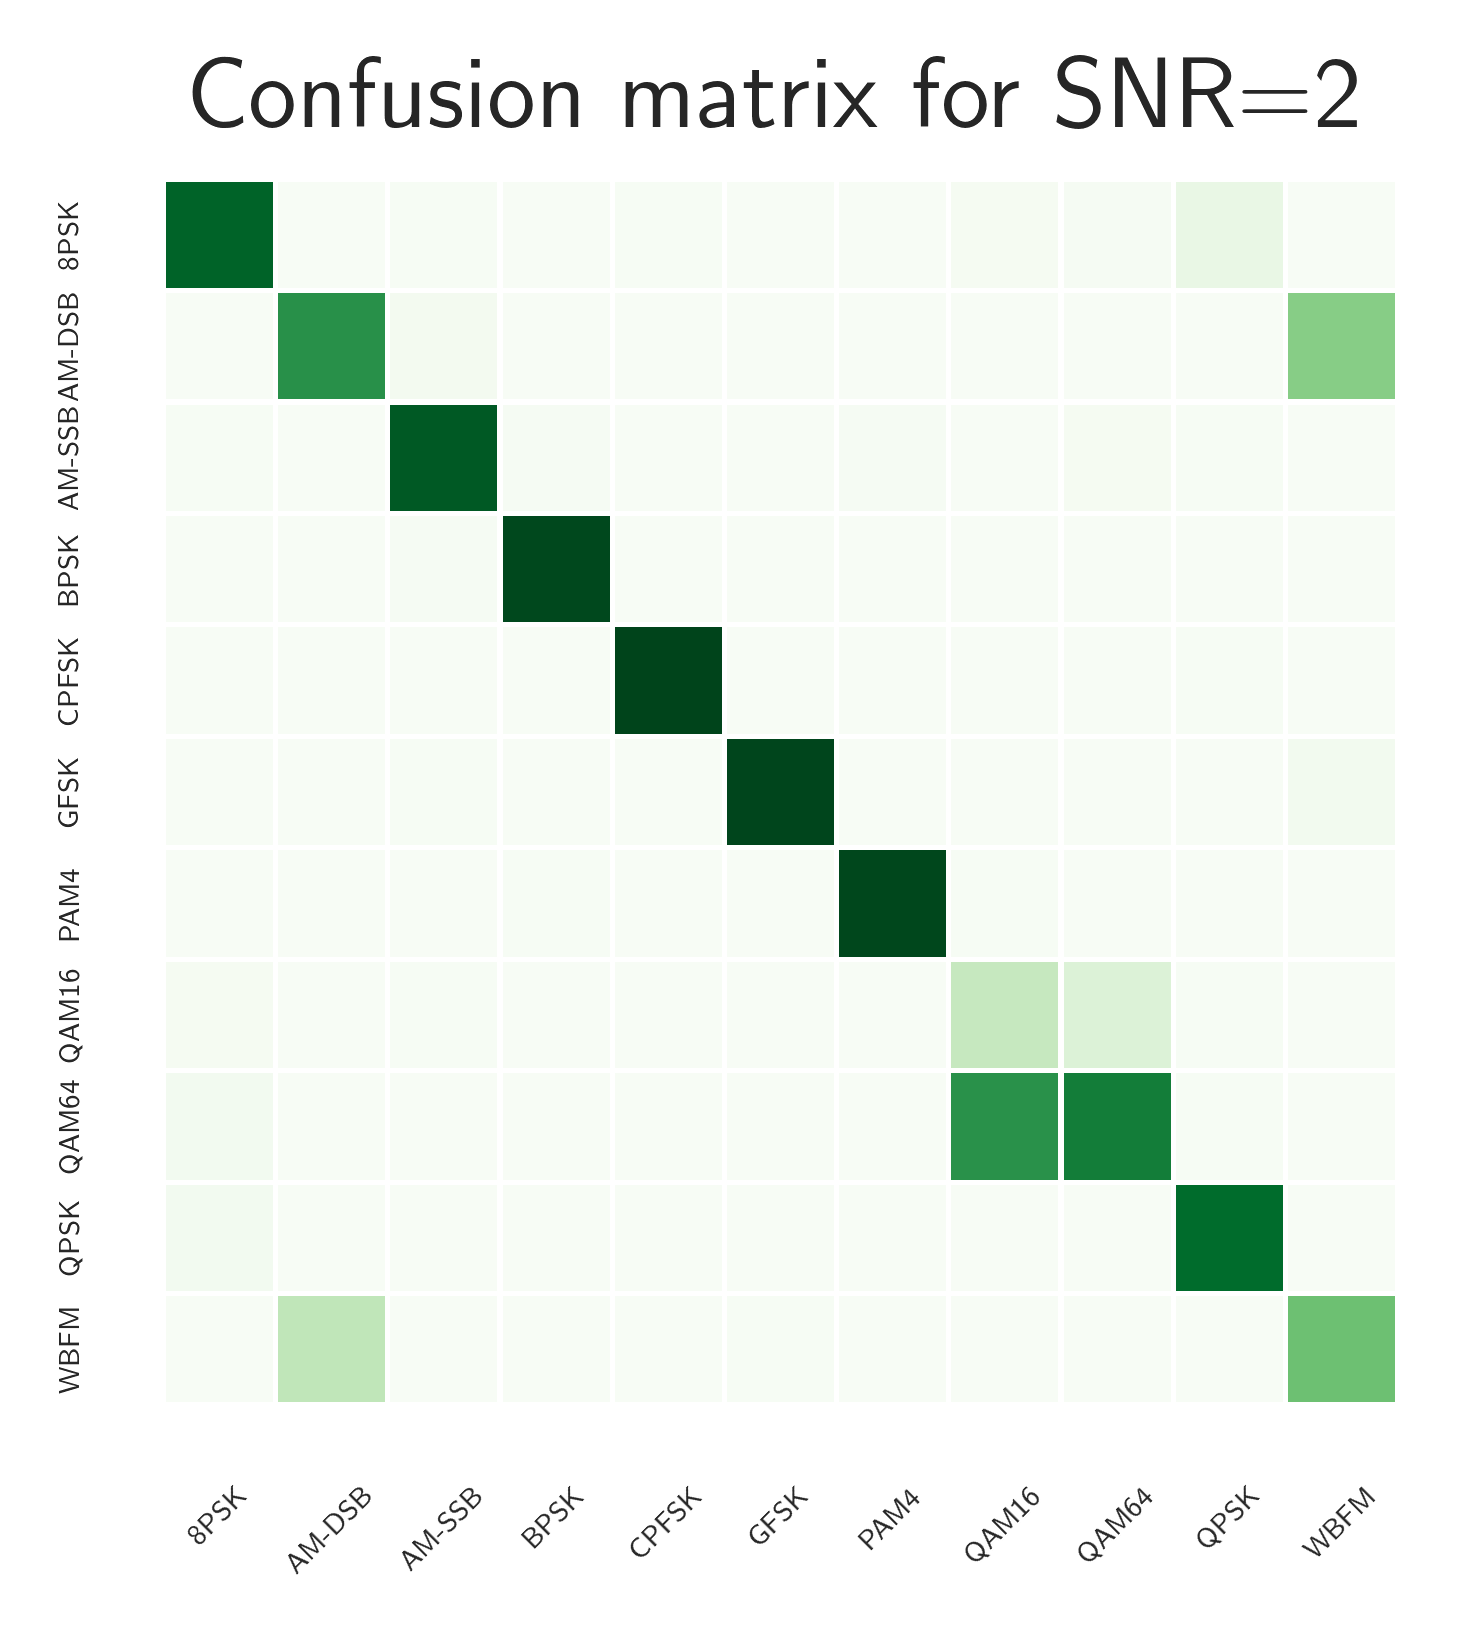

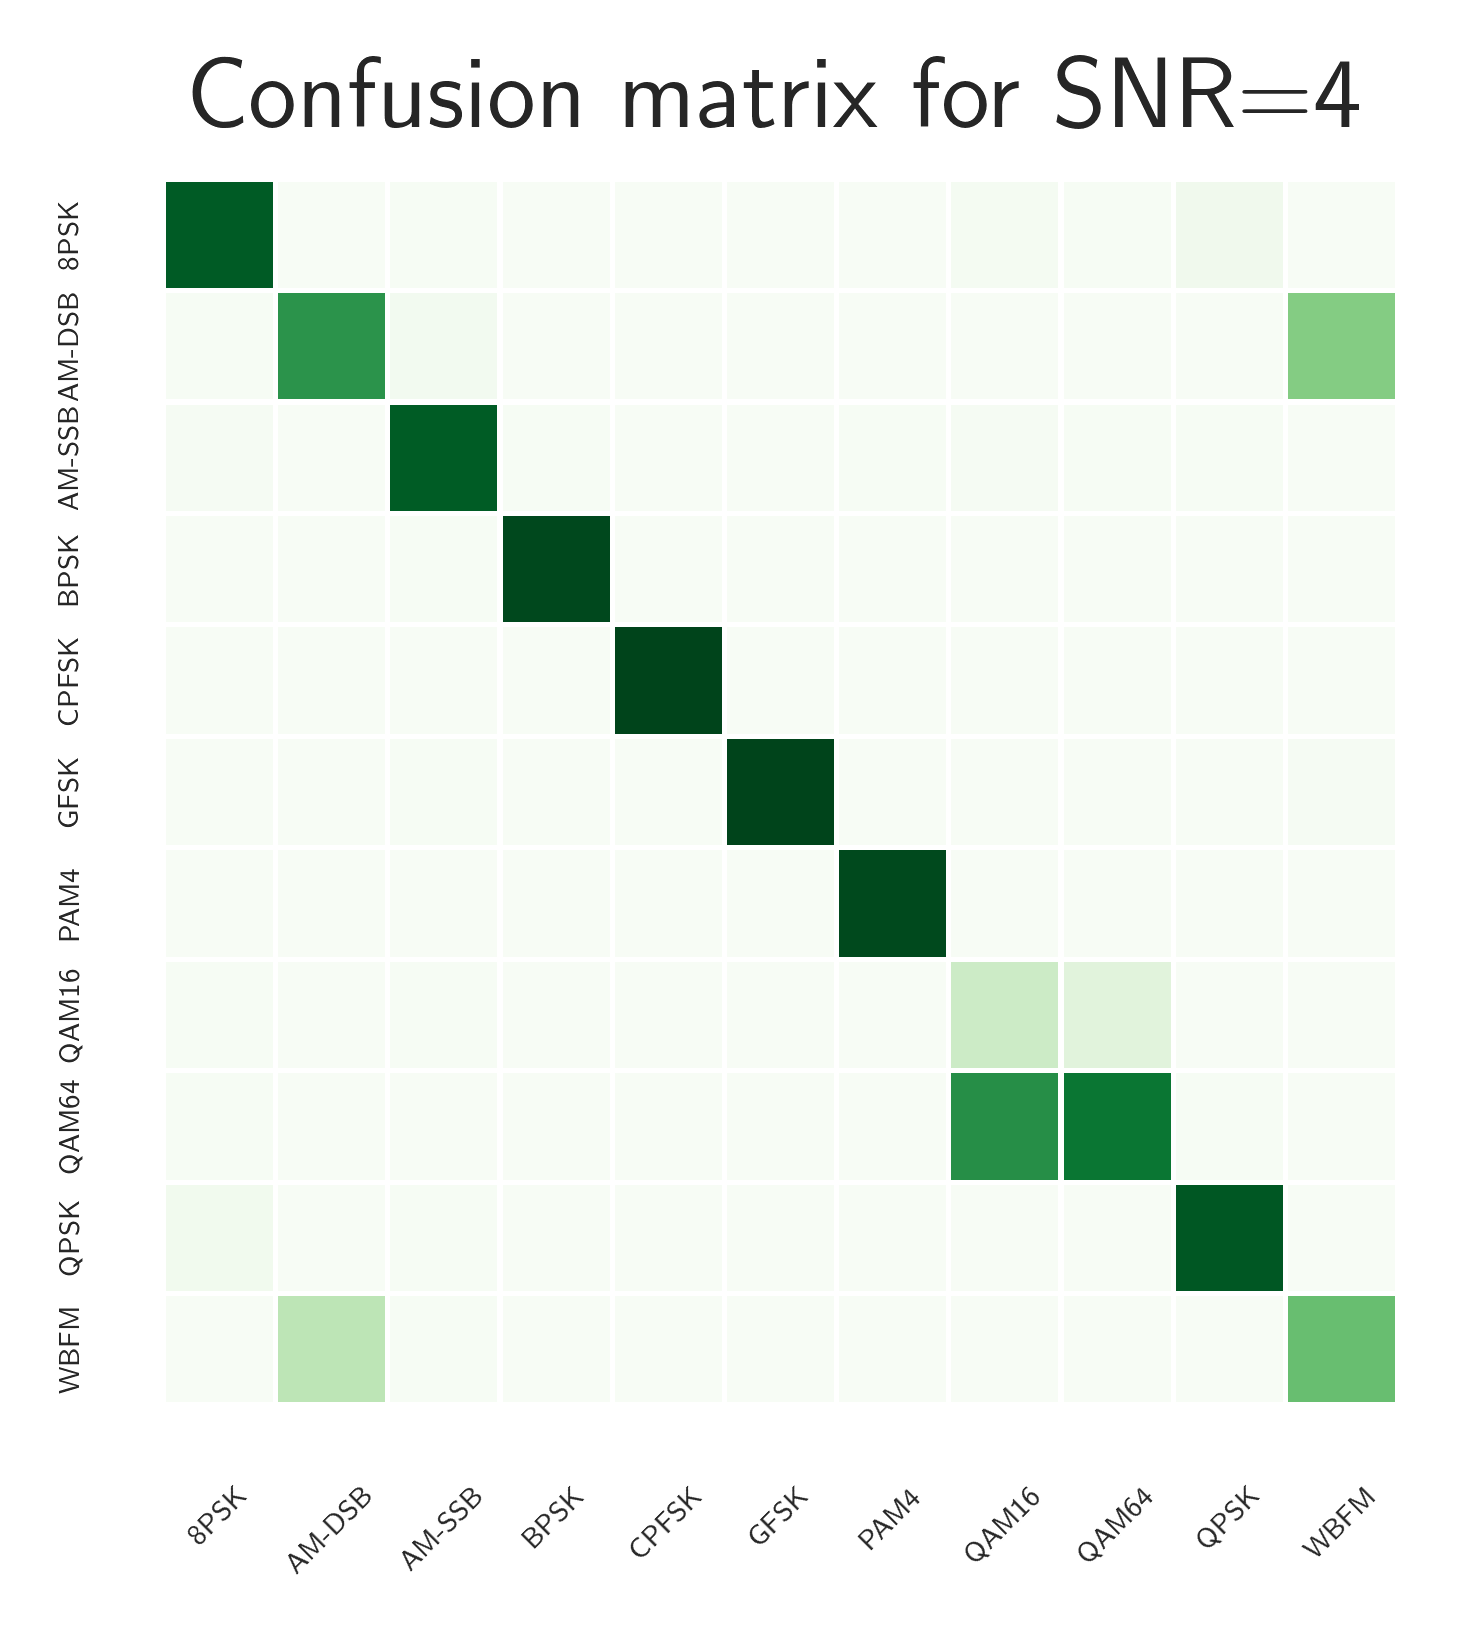

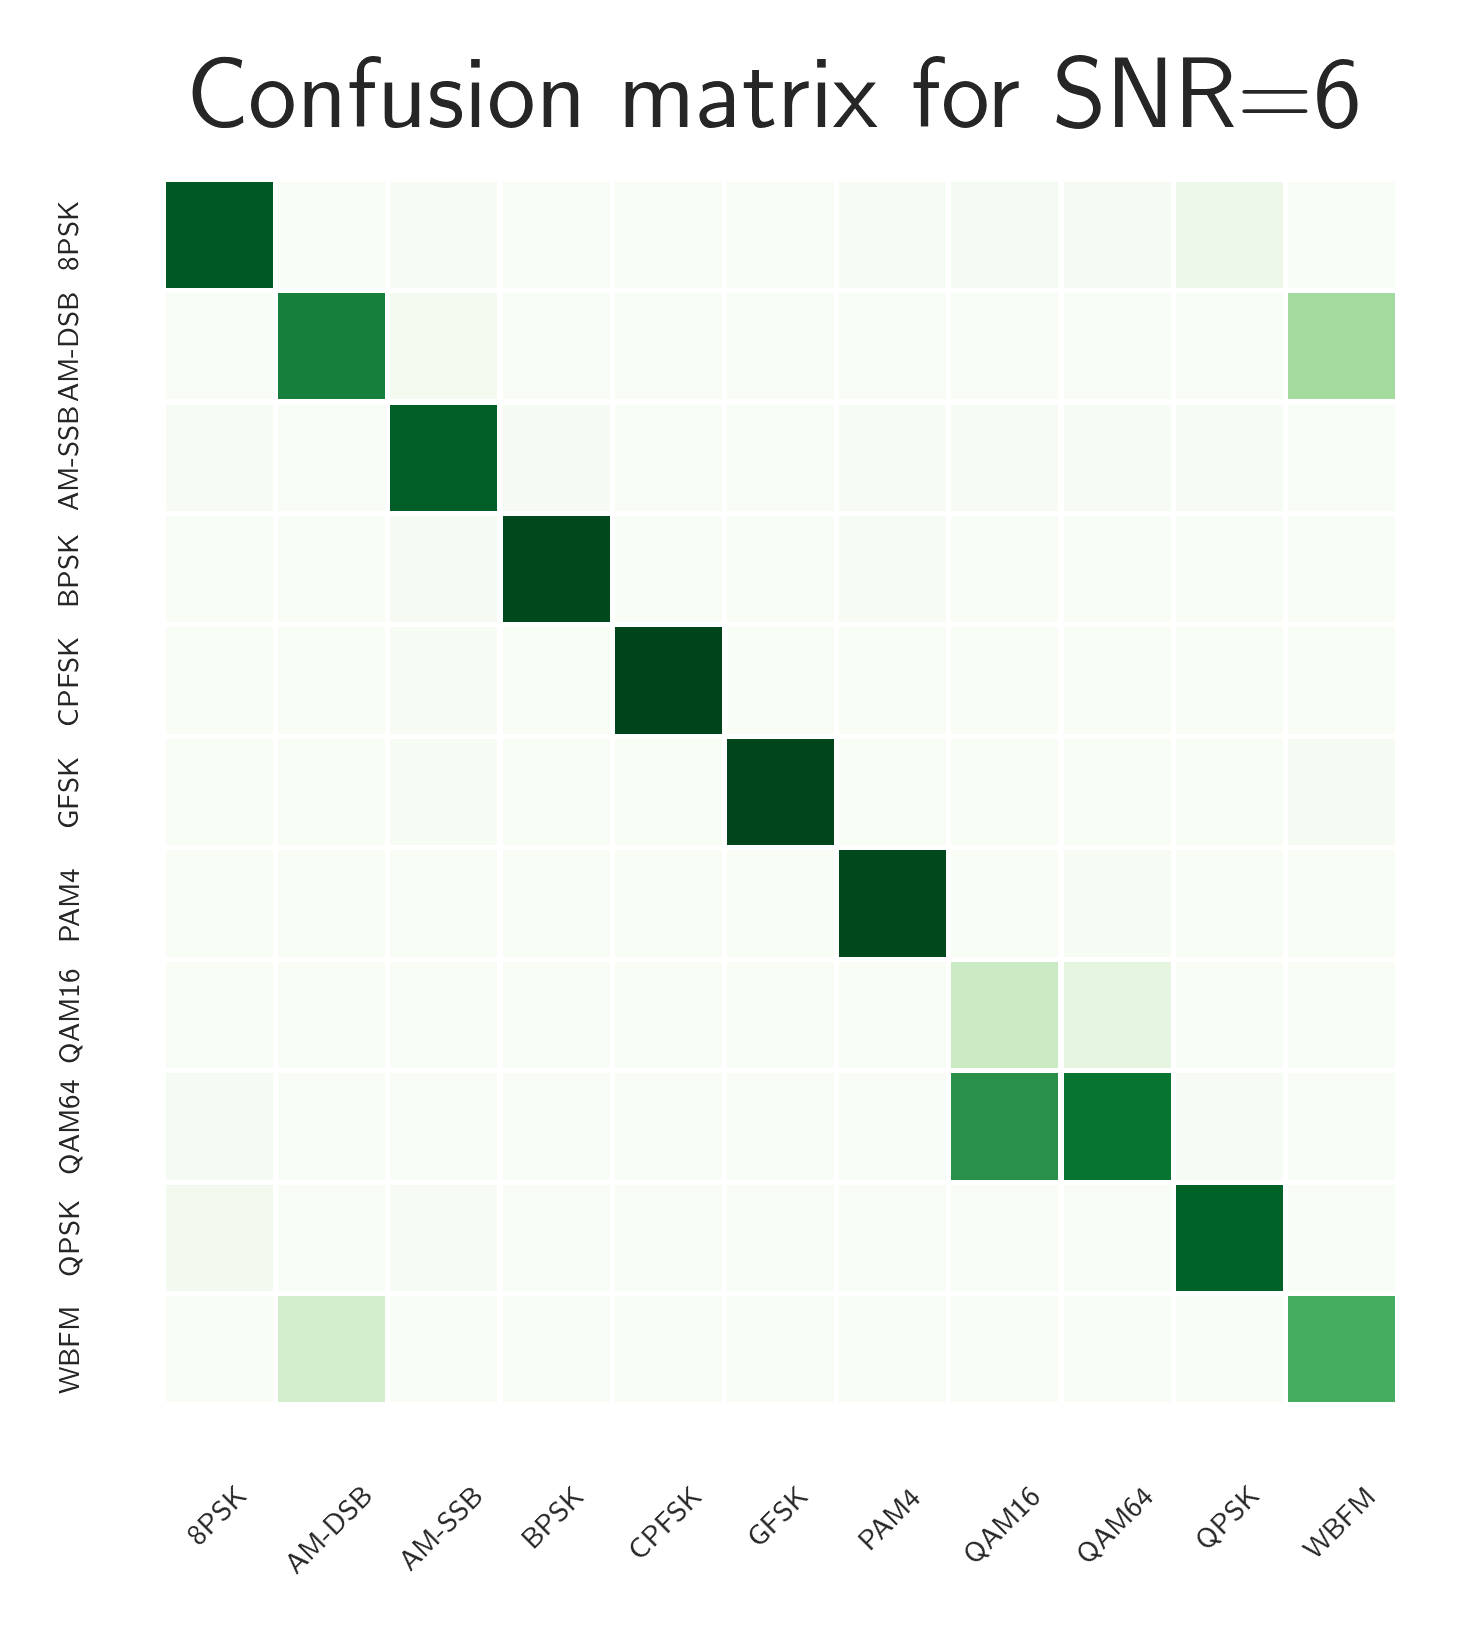

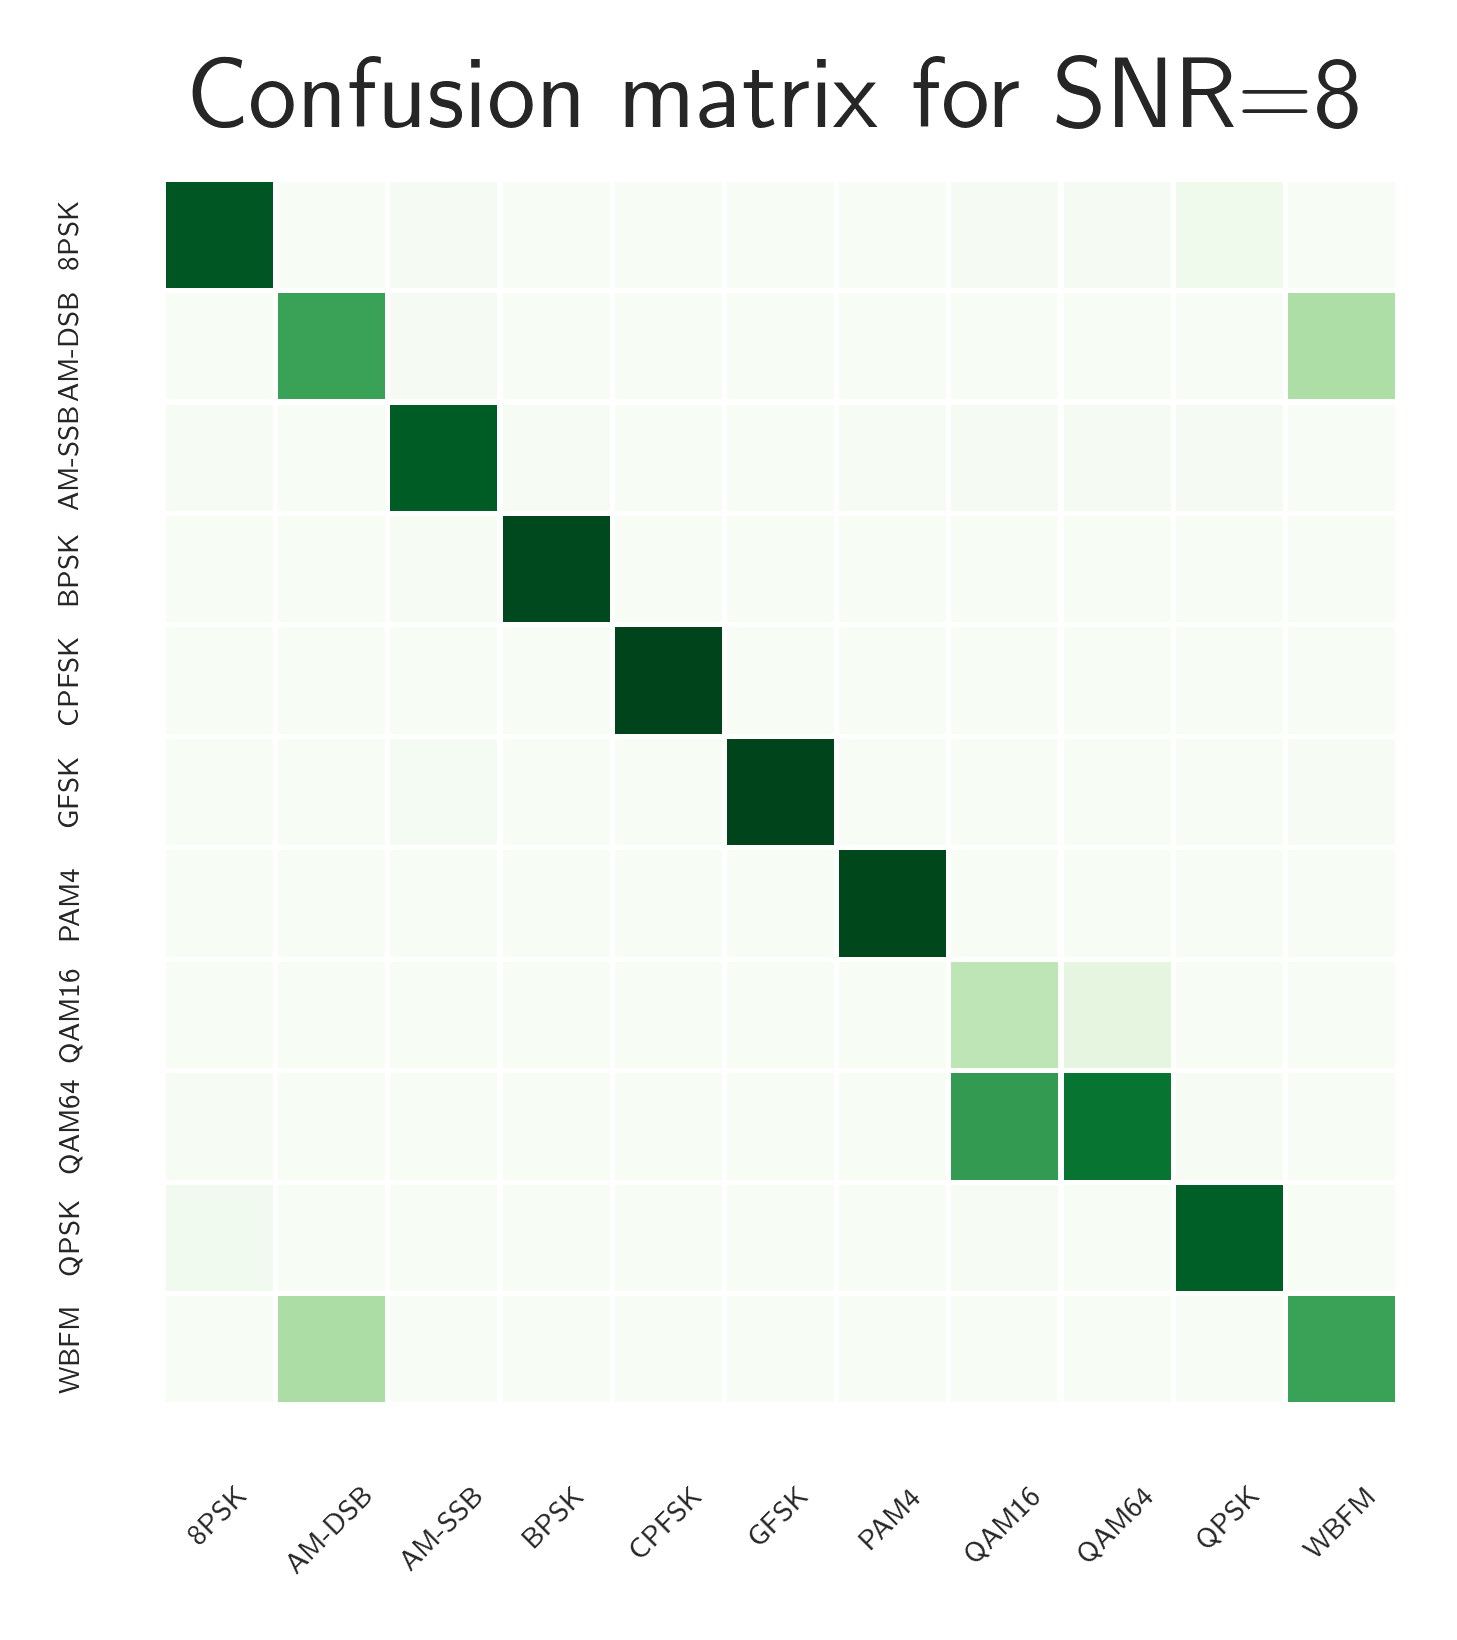

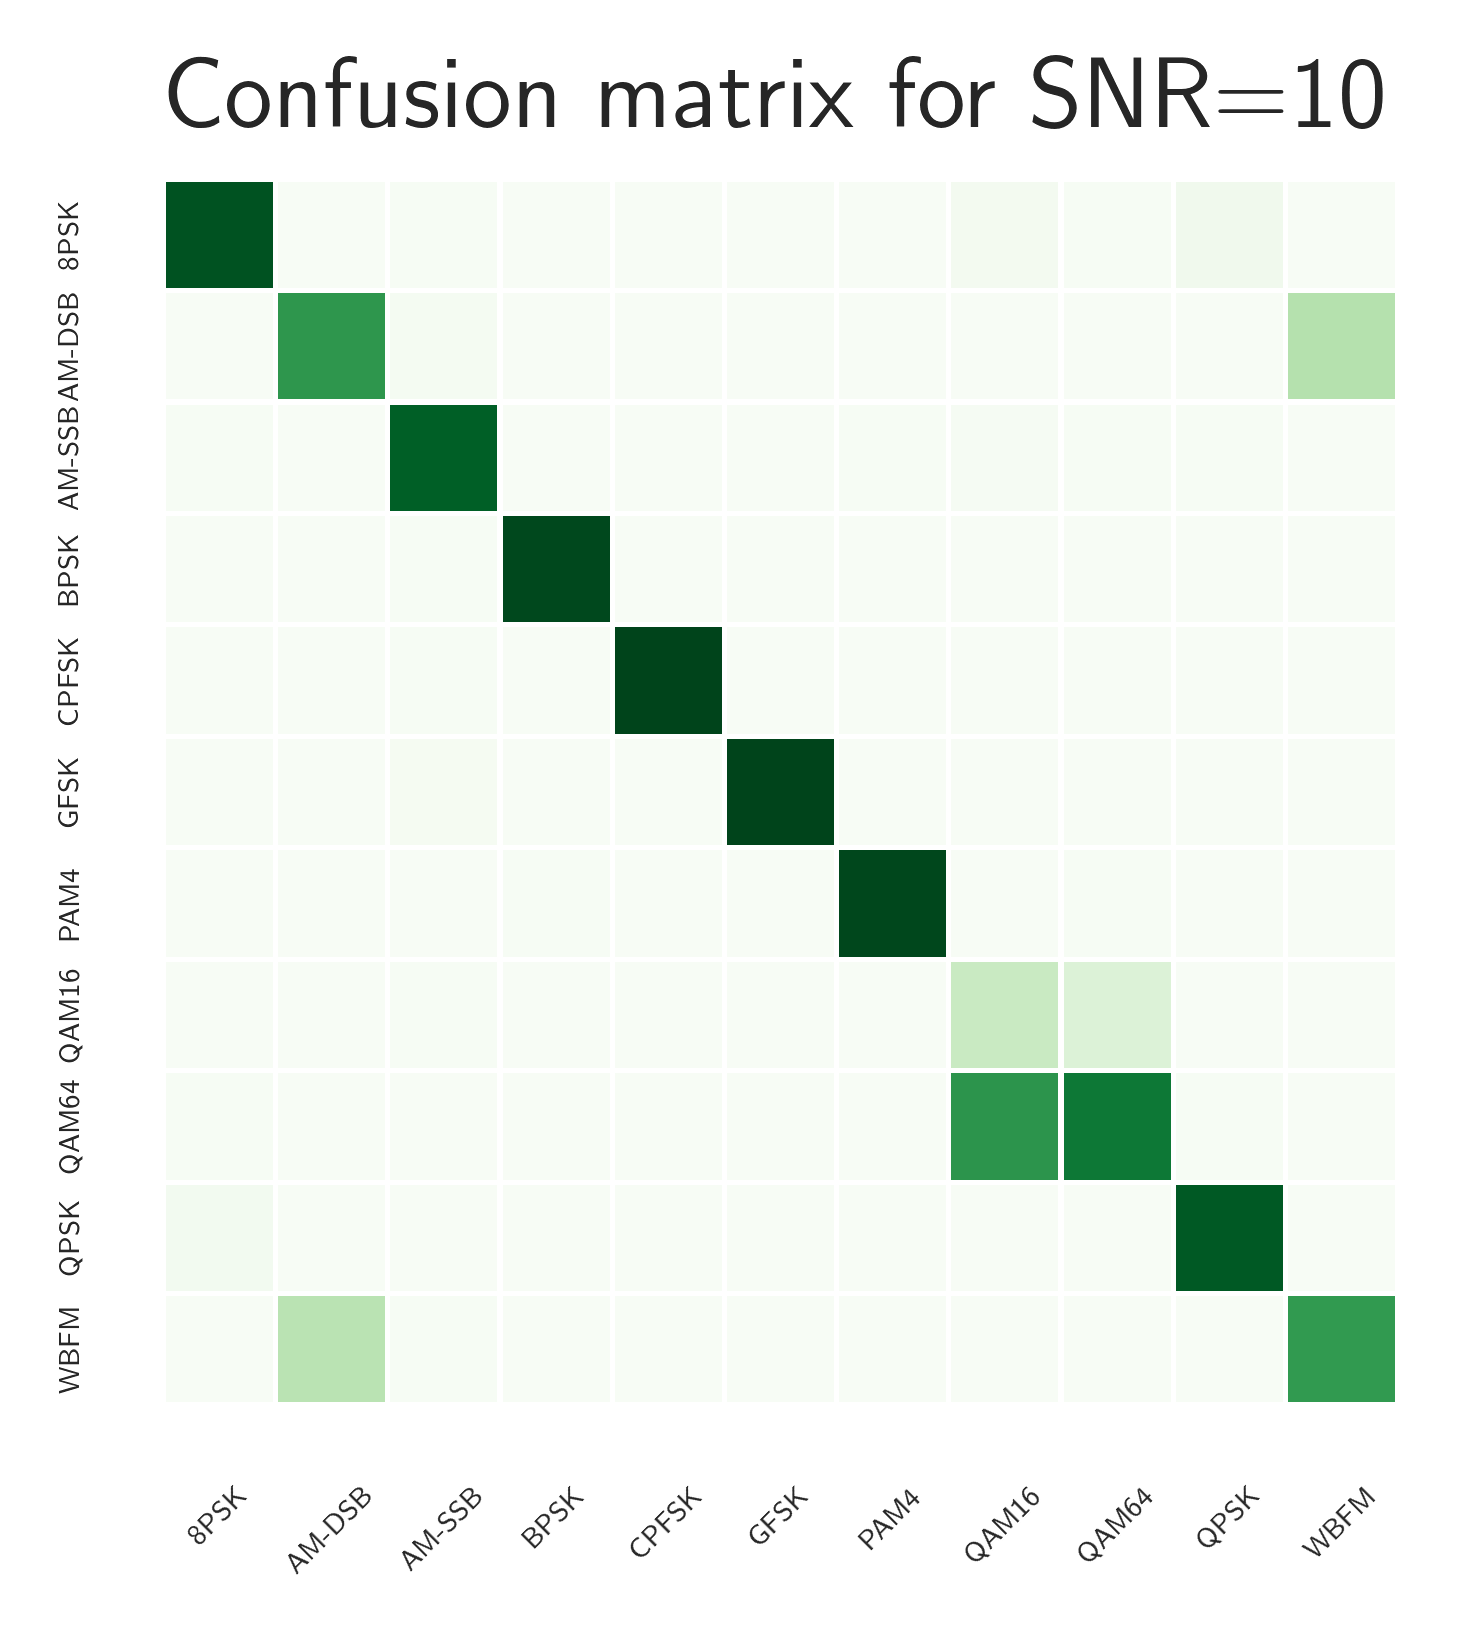

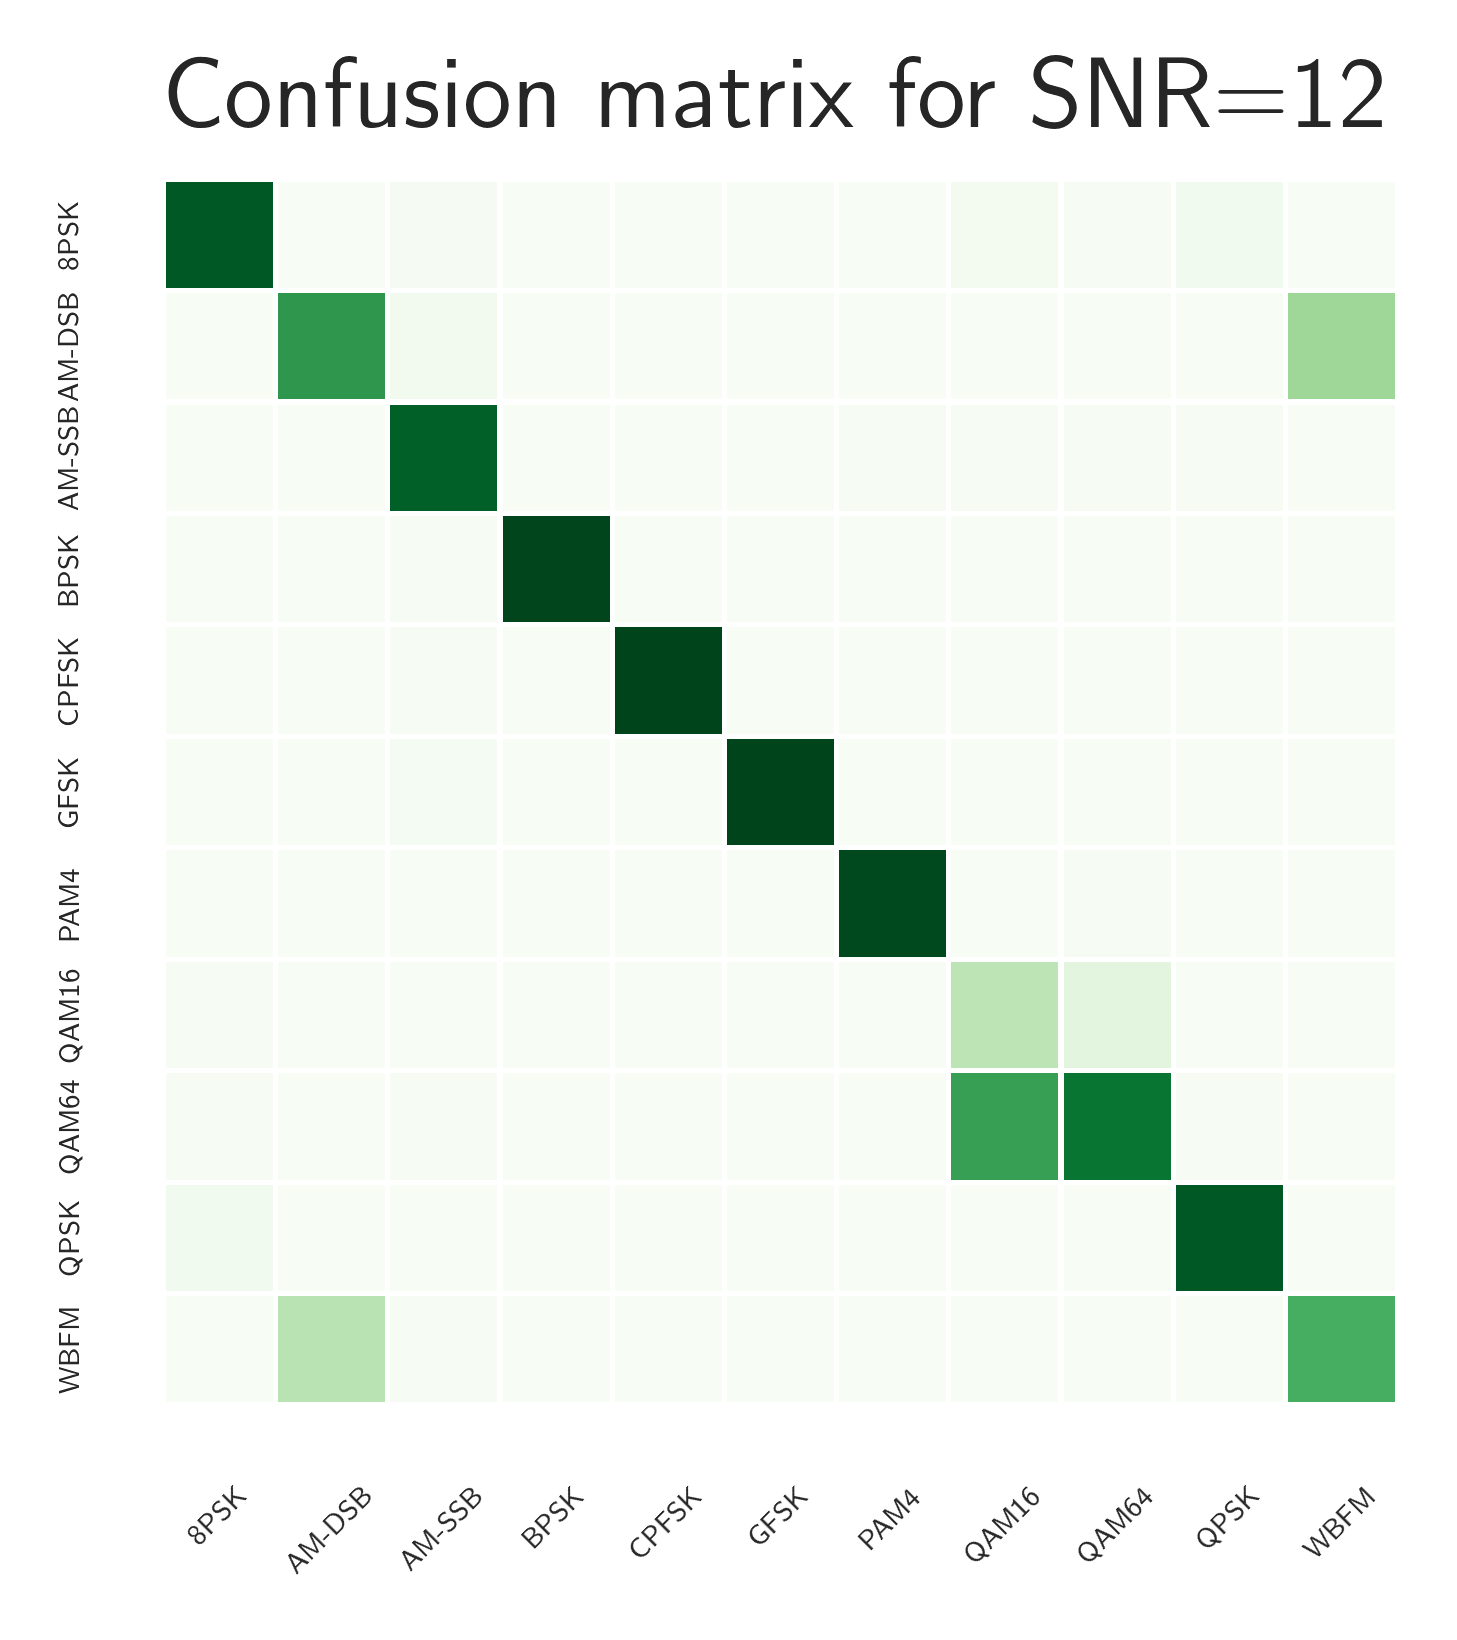

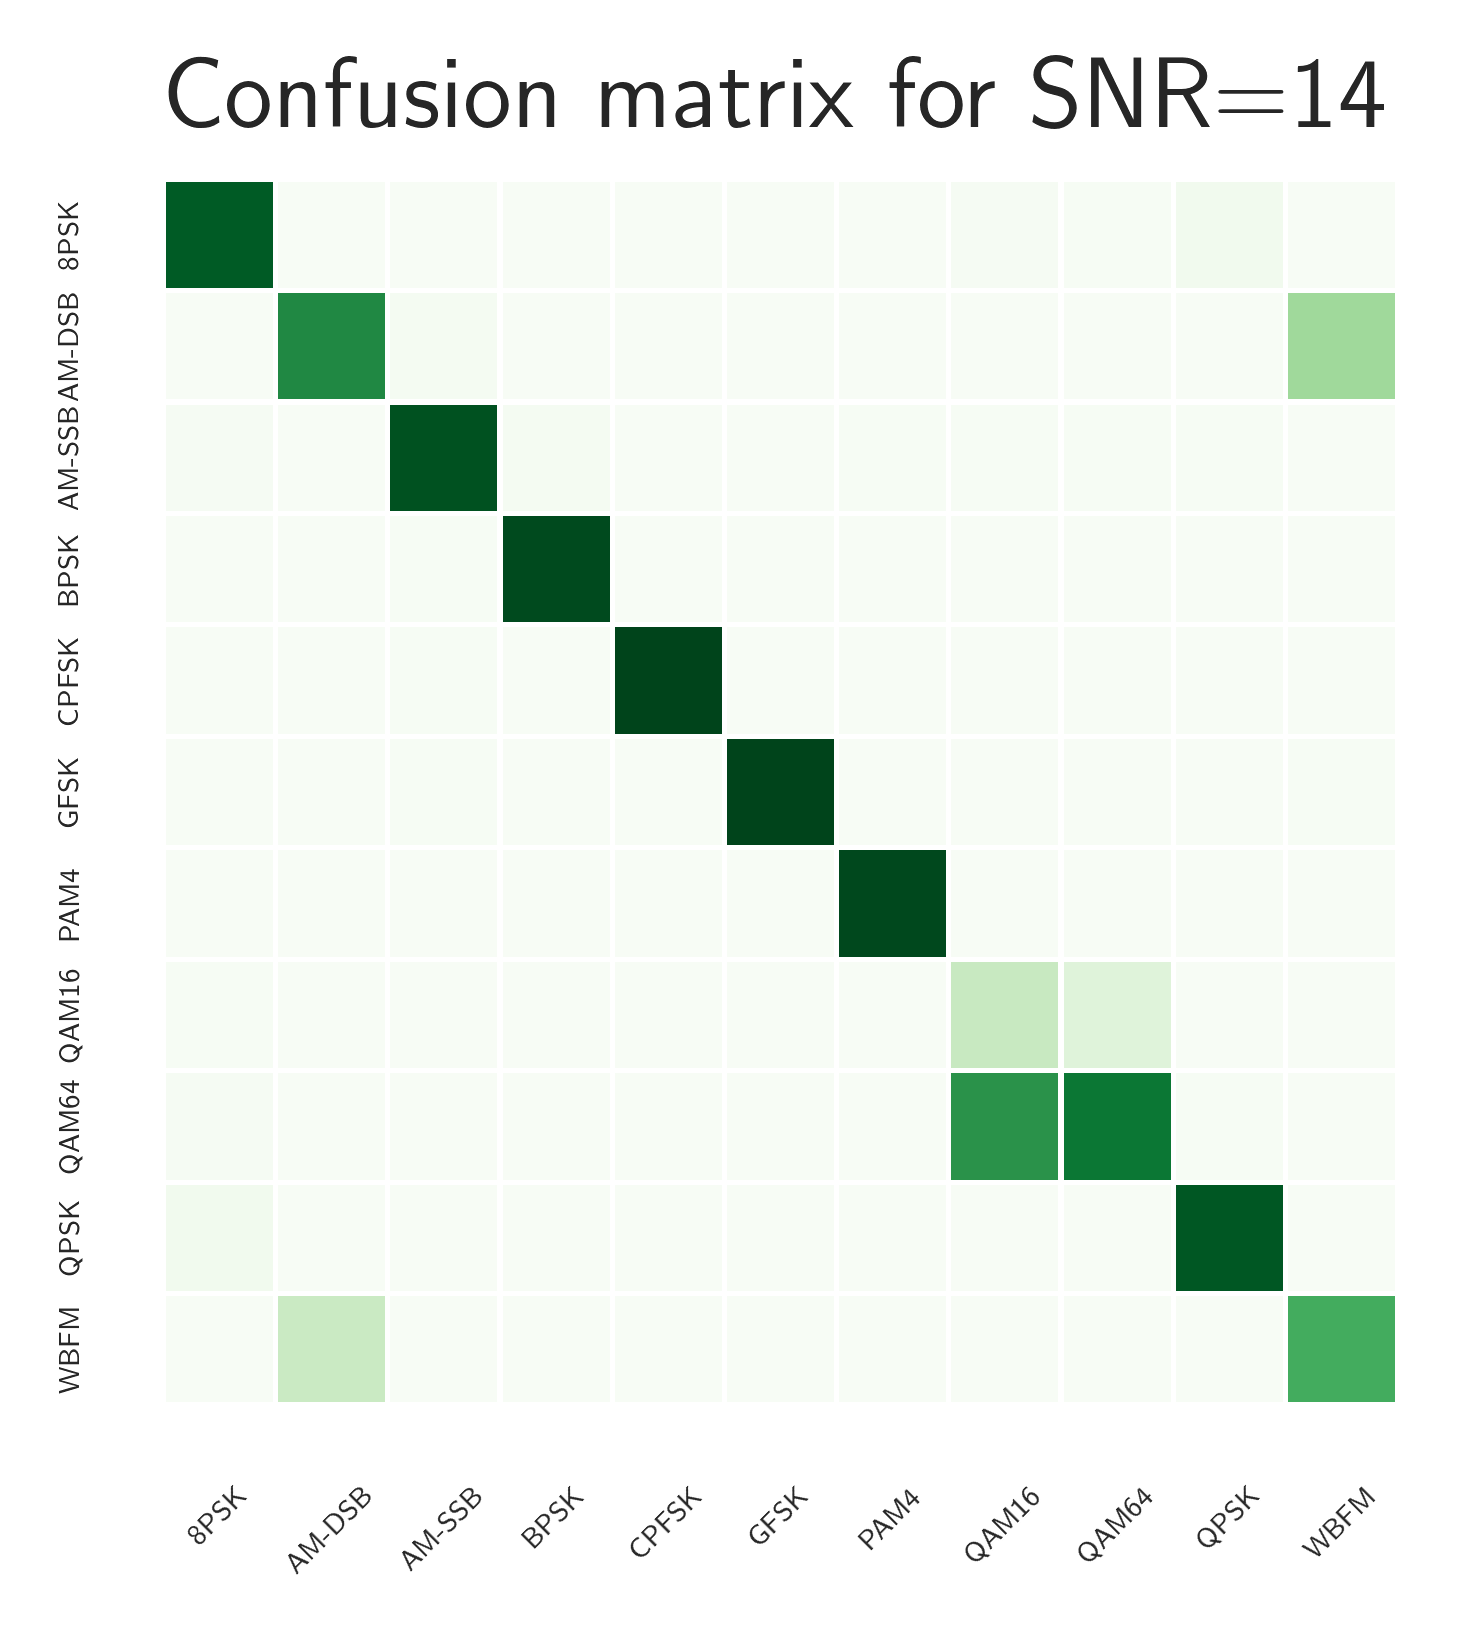

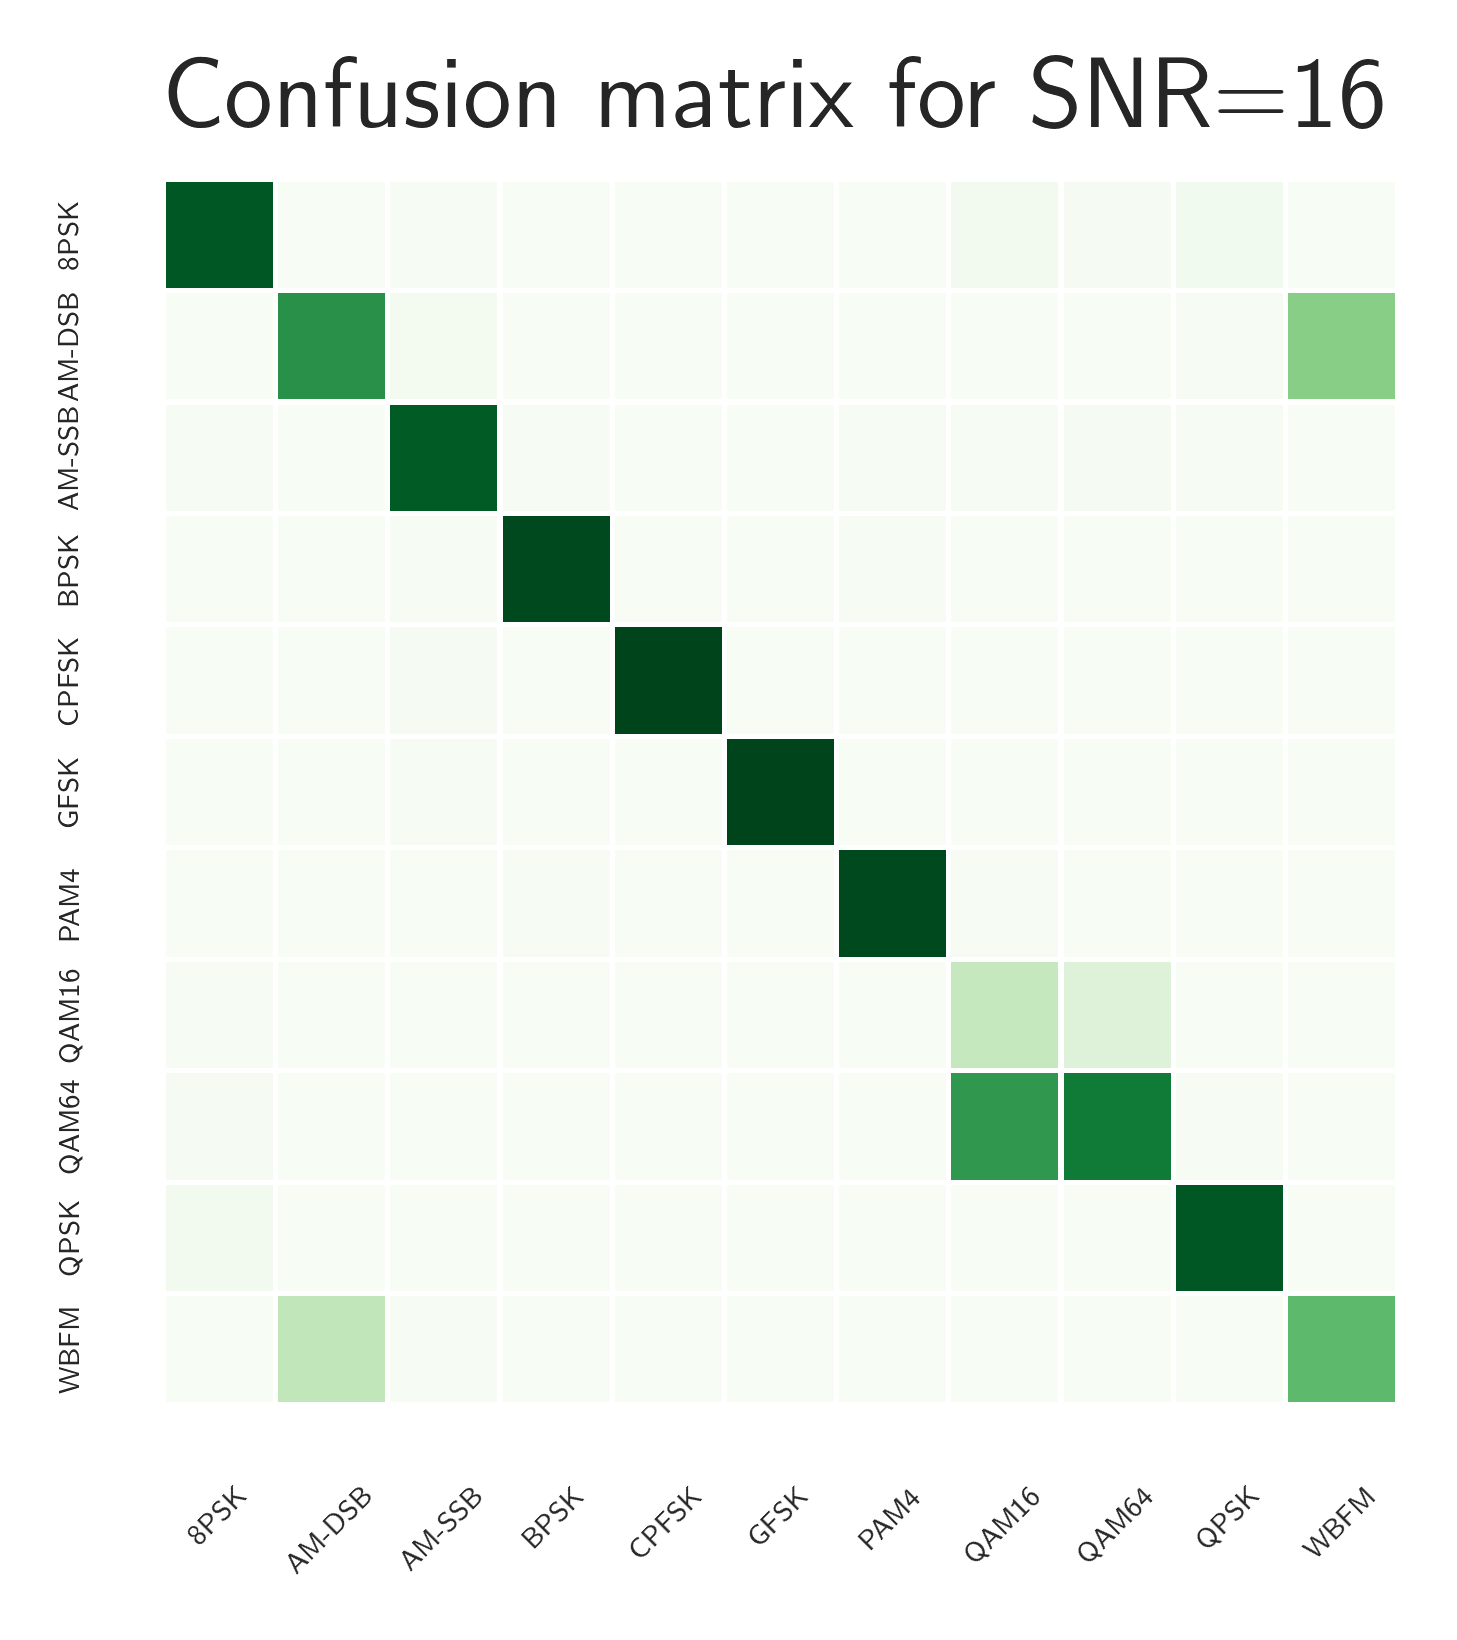

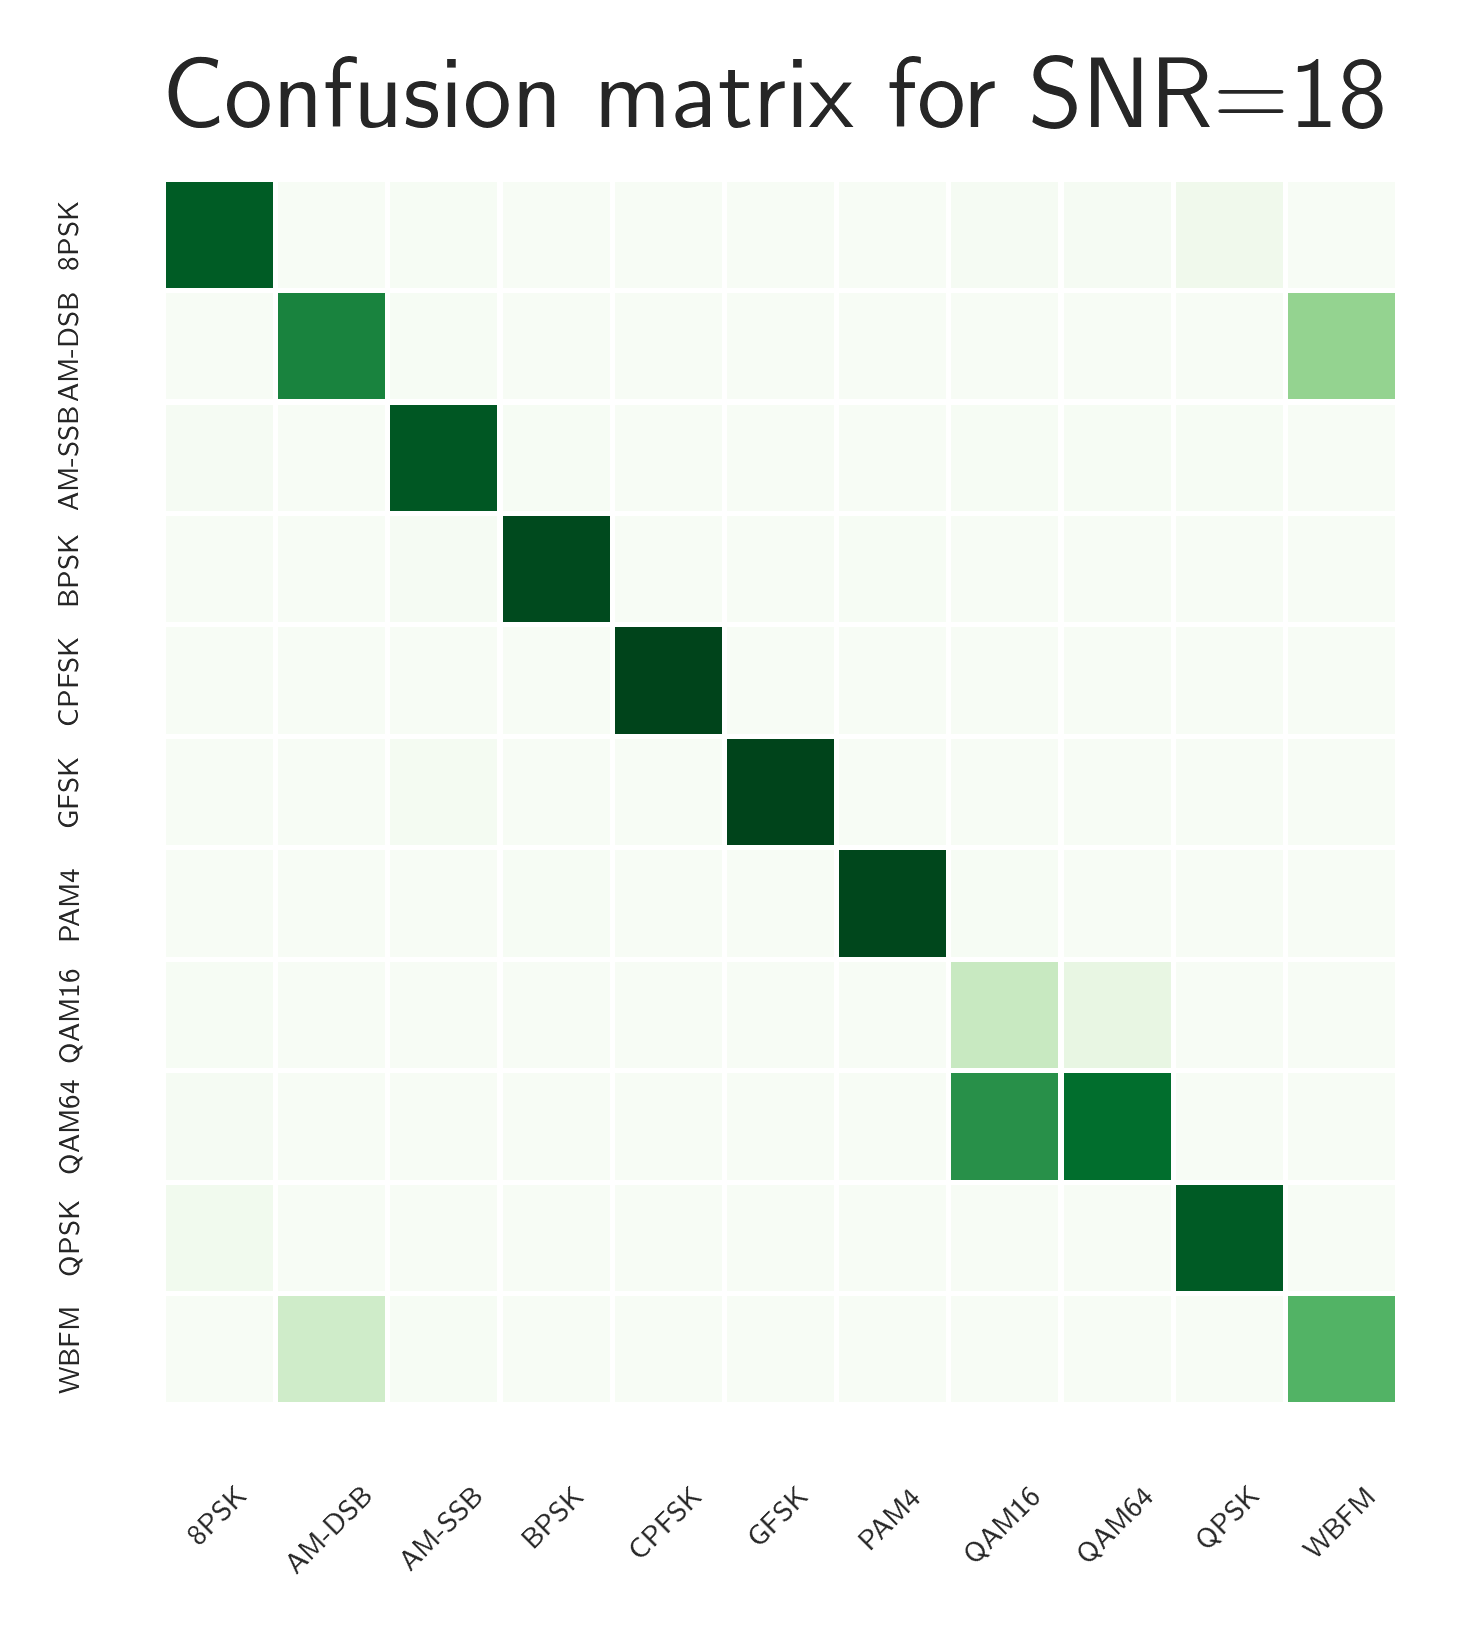

In [ ]:
acc = {}
test_SNRs = np.array( list(map(lambda x: lbl[x][1], test_idx) ) )
accuracies = list()
for snr in snrs:

    # extract classes @ SNR
    #print(np.where(np.array(test_SNRs))==snr)
    #test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    #test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_X_i = X_test[np.nonzero(test_SNRs == snr)]
    test_Y_i = Y_test[np.nonzero(test_SNRs == snr)]
    #test_X_i = np.expand_dims( test_X_i, axis = 1 )
    if ( test_X_i.shape[0] == 0 ):
      continue
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i, batch_size = 1024 )
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[k,j] = conf[k,j] + 1
    for i in range(0,len(classes)):
        confnorm[:,i] = conf[:,i] / np.sum(conf[:,i])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    plot_small_confusion("Confusion matrix for SNR="+str(snr), confnorm, classes,"BiLSTM_CM_" + str(snr) + ".png")
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    accur = cor / ( cor + ncor )
    print("Overall Accuracy: ", accur)
    acc[snr] = 1.0*cor/(cor+ncor)
    accuracies.append(accur)
    #plt.plot(snr, cor/(cor+ncor))

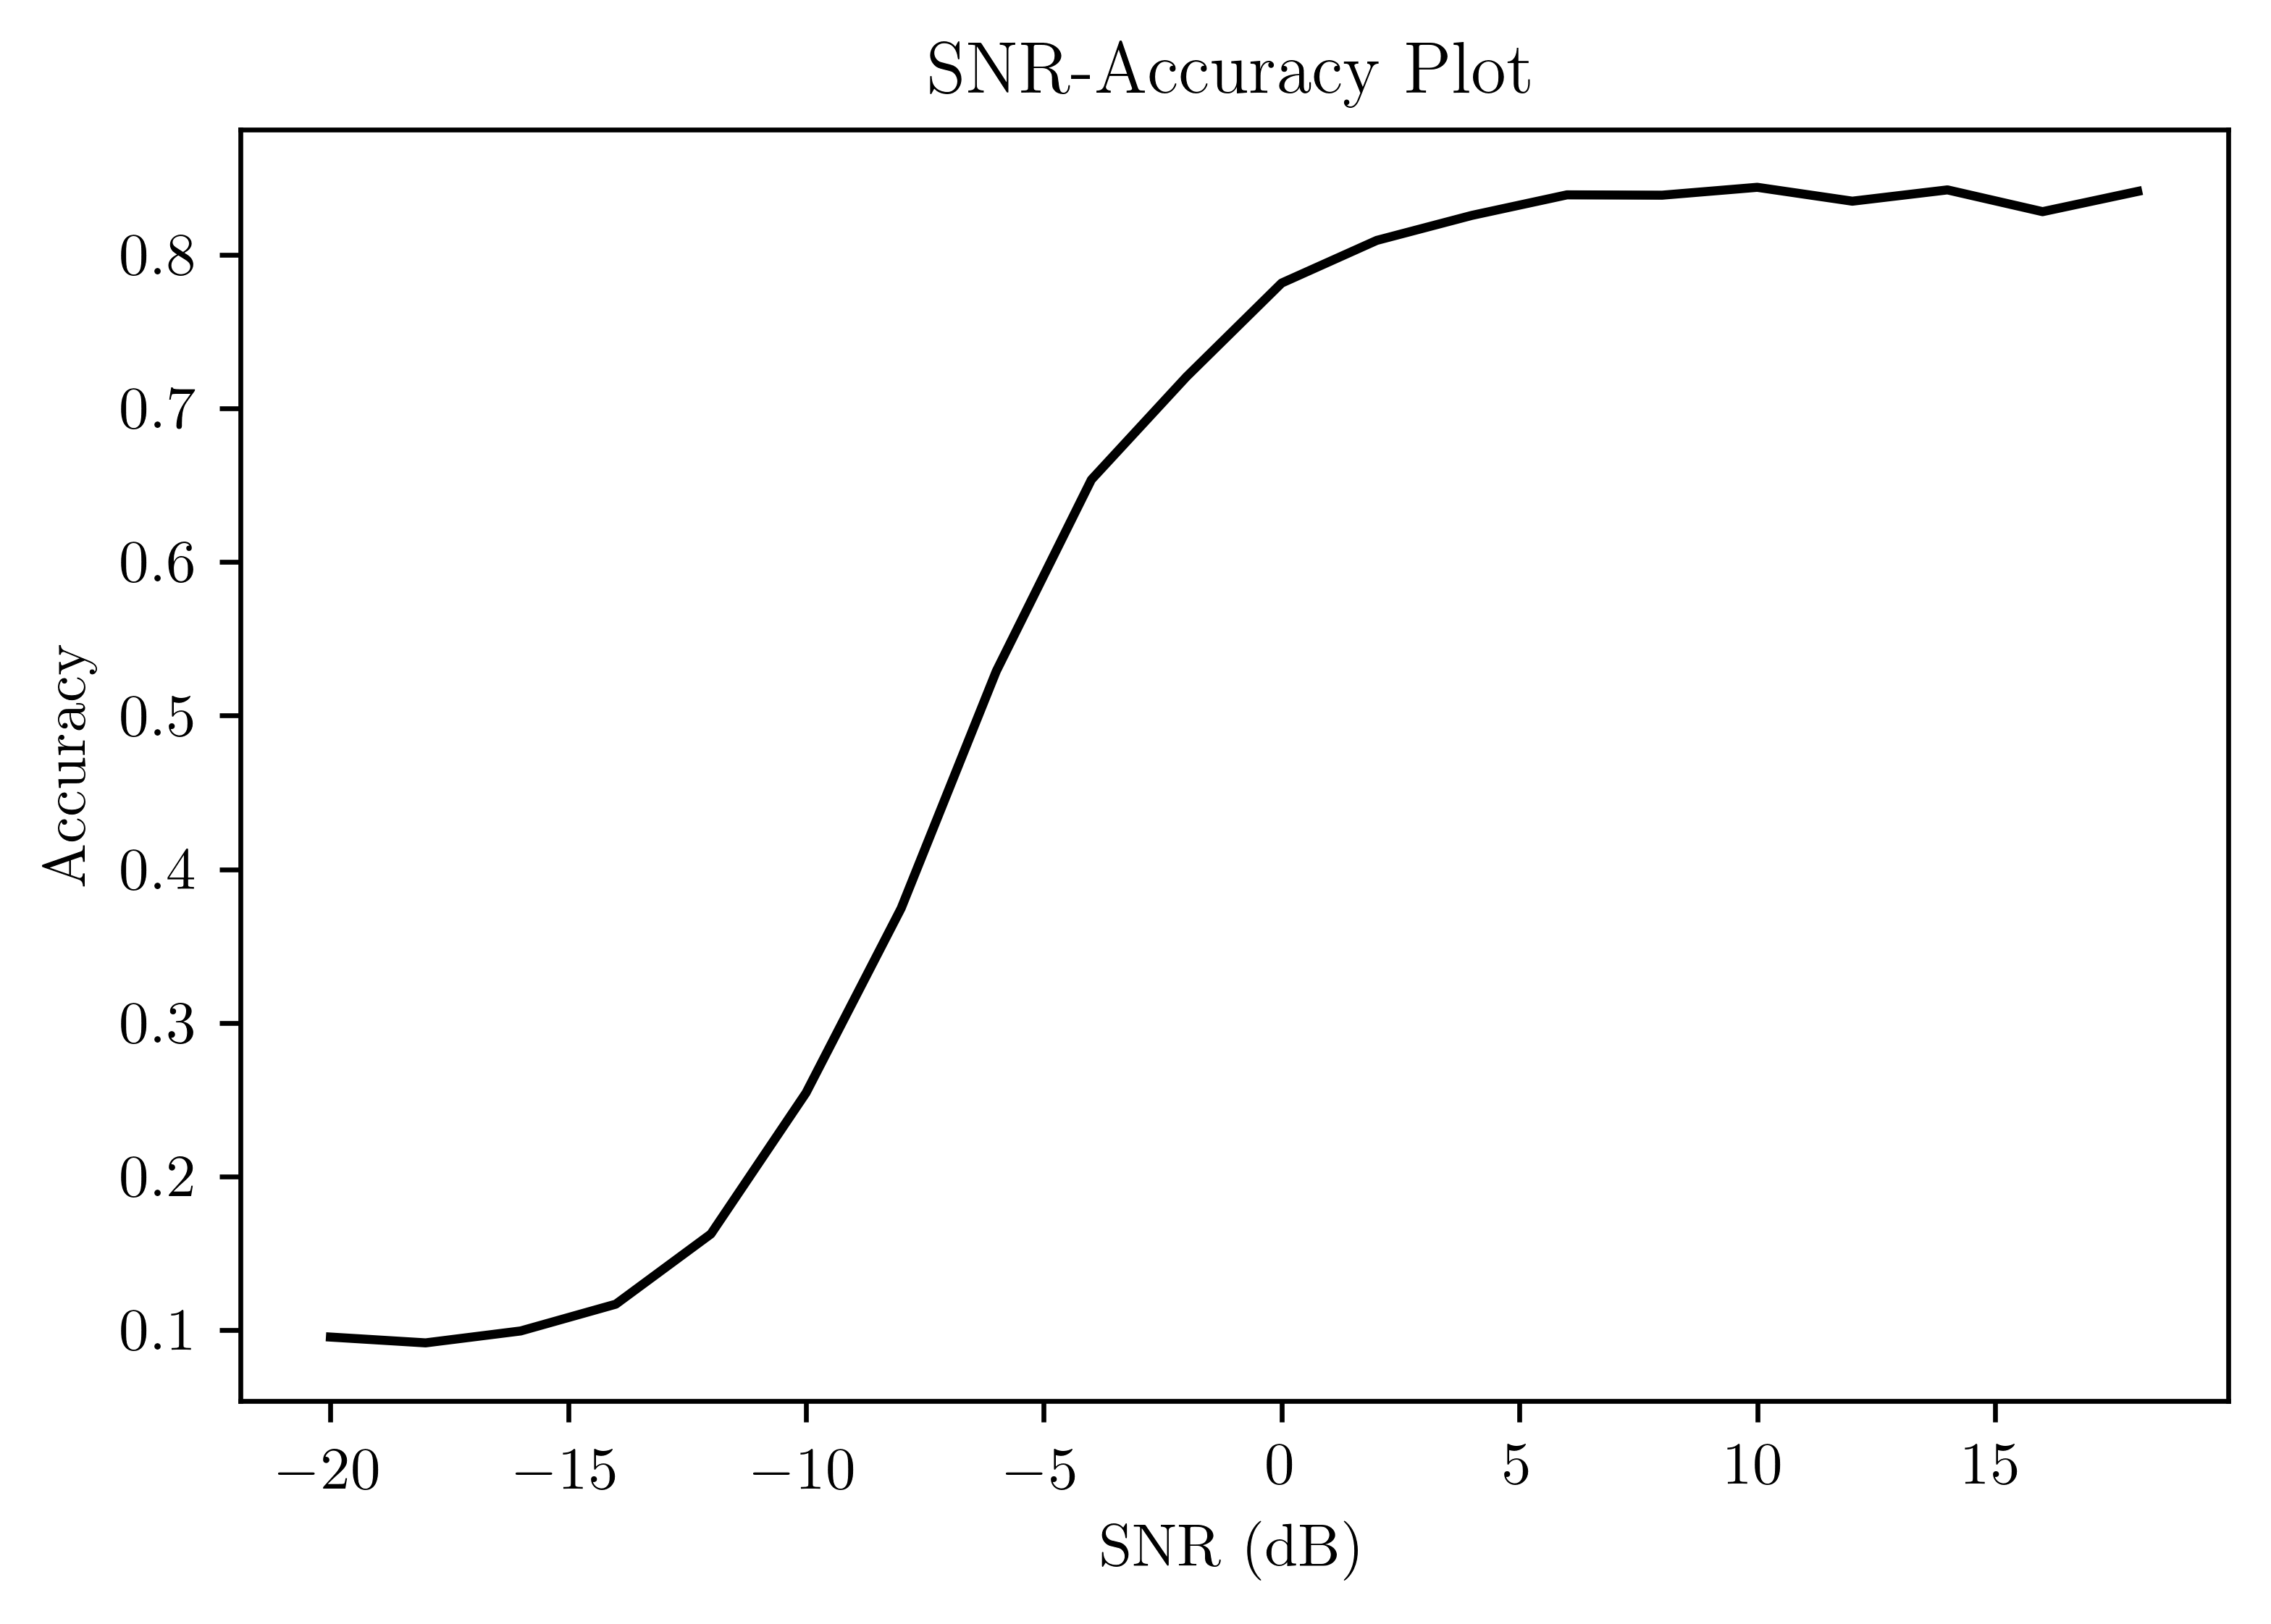

In [ ]:
#sn.set(font_scale=1.0) # for label size

#plt.style.use("default")

#fig = plt.figure()
matplotlib.pyplot.figure(figsize=(textwidth-0.2,3.8), dpi=600)
#fig.patch.set_facecolor("white")

plt.title('SNR-Accuracy Plot', fontsize="12")
ax = plt.plot(snrs,accuracies, color="black")
plt.grid(b=False)
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.savefig("BiLSTM_SNR_Acc.png", bbox_inches="tight")
plt.show()

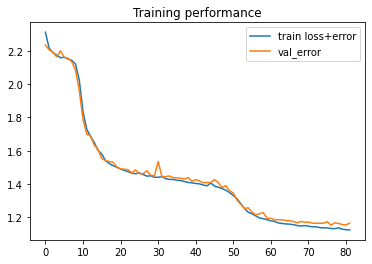

In [ ]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(110000, 128, 2)


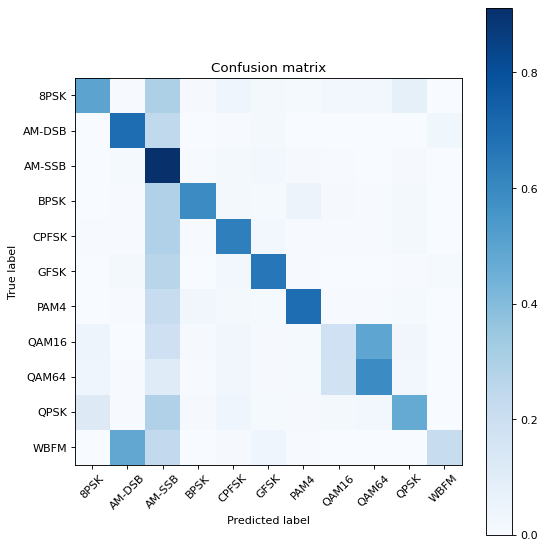

In [ ]:
print(X_test.shape)
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(7, 7), dpi=80)

plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.09533394327538884
Overall Accuracy:  0.09137148047229791
Overall Accuracy:  0.0955137481910275
Overall Accuracy:  0.11764705882352941
Overall Accuracy:  0.18122151321786692
Overall Accuracy:  0.2640838812866536
Overall Accuracy:  0.3679955906669116
Overall Accuracy:  0.5078812316715543
Overall Accuracy:  0.6242144177449168
Overall Accuracy:  0.7144412191582002
Overall Accuracy:  0.7791970802919708
Overall Accuracy:  0.7926208651399491
Overall Accuracy:  0.8147944199706314
Overall Accuracy:  0.8081227436823105
Overall Accuracy:  0.8250676284941388
Overall Accuracy:  0.8225865209471767
Overall Accuracy:  0.8209306536302734
Overall Accuracy:  0.8210001845358922
Overall Accuracy:  0.8153846153846154
Overall Accuracy:  0.8178217821782178


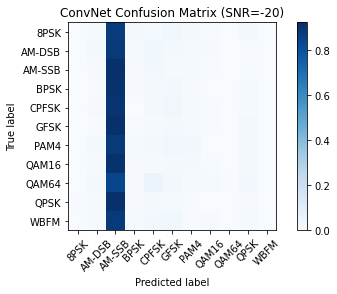

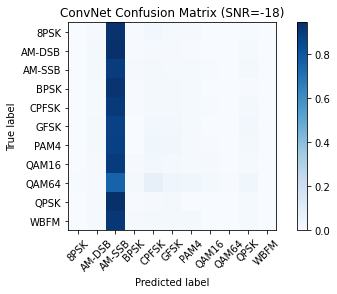

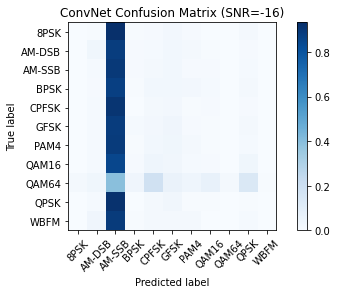

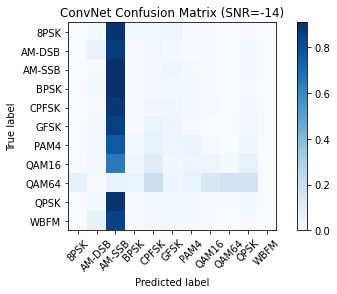

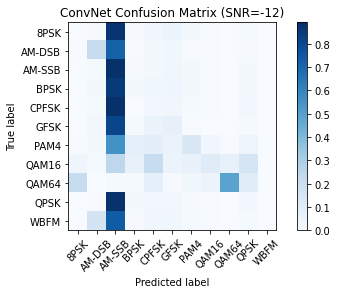

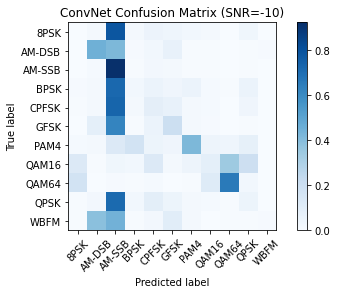

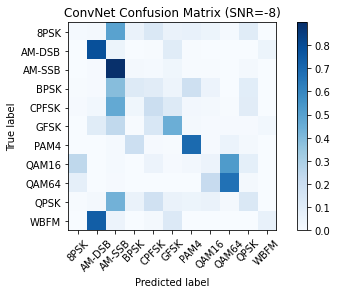

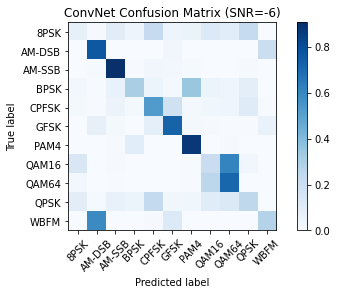

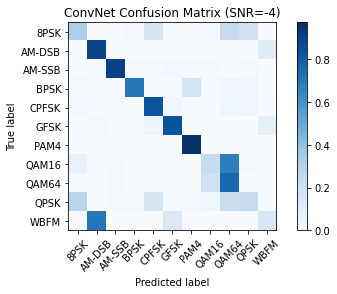

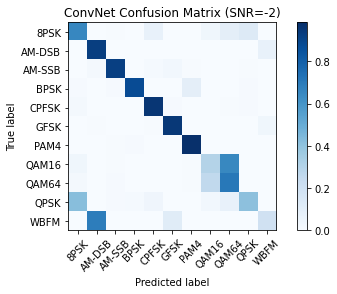

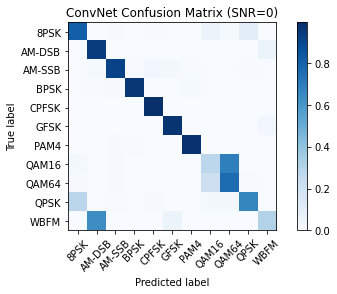

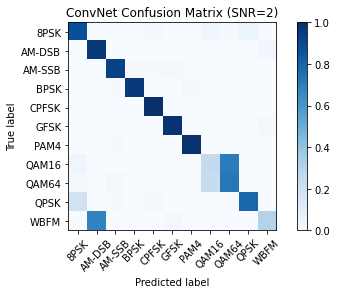

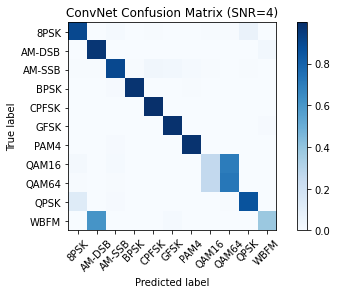

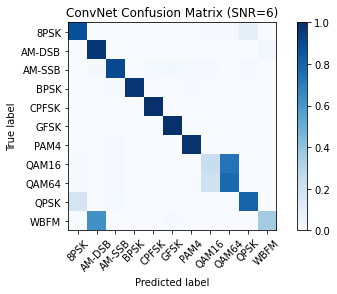

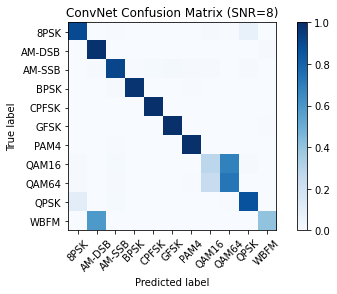

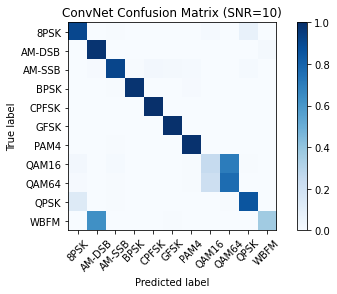

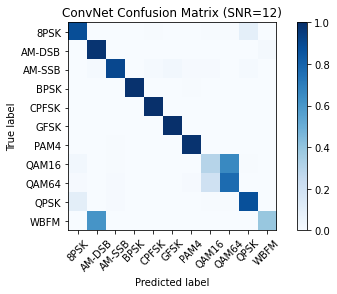

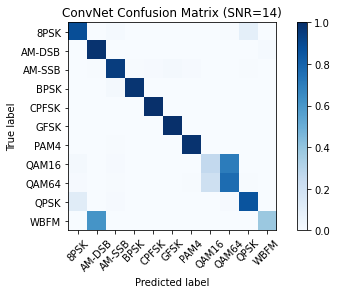

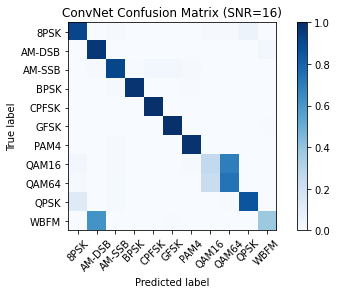

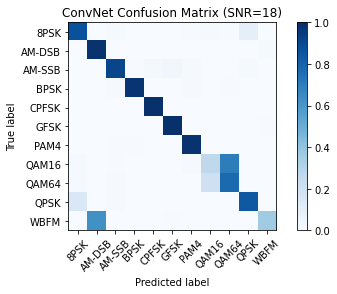

In [ ]:
acc = {}
test_SNRs = np.array( list(map(lambda x: lbl[x][1], test_idx) ) )
for snr in snrs:

    # extract classes @ SNR
    #print(np.where(np.array(test_SNRs))==snr)
    #test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    #test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    test_X_i = X_test[np.nonzero(test_SNRs == snr)]
    test_Y_i = Y_test[np.nonzero(test_SNRs == snr)]
    #test_X_i = np.expand_dims( test_X_i, axis = 1 )
    if ( test_X_i.shape[0] == 0 ):
      continue
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i, batch_size = 1024 )
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)